In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                        past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                    past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0
        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS-CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
        
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS-CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            np.save(train_acc_file_name, train_acc_array)
            np.save(val_acc_file_name, val_acc_now_array)
            with open(hyperparameters_file_name, 'w') as f:
                json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32

                # DVS-CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS-CIFAR10',# 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS-CIFAR10'
                CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0, # nda 0.5  # ottt 1.0
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],


                net_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001,  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 50, #숫자 크게 하면 꺼짐
                validation_interval = 50, #숫자 크게 하면 꺼짐
                tdBN_on = False,  # True # False
                BN_on = True,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


My Num of PARAMS: 9,404,234, system's param_num : 9,459,274
Memory: 35.87MiB at 32-bit
EPOCH 0


train: 0-48/71 tr_acc: 30.47%, lr=['0.001'], tr_loss: 1.8536916971206665, val_acc: 0.00%:  69%|██████▉   | 49/71 [01:48<00:42,  1.93s/it]

0-49 training acc: 34.38%, lr=['0.001'], val_acc: 0.00%
iter_one_train_time: 1.9421370029449463 seconds, last one_val_time: 0 seconds



train: 0-70/71 tr_acc: 40.00%, lr=['0.001'], tr_loss: 1.5720982551574707, val_acc: 27.20%: 100%|██████████| 71/71 [02:33<00:00,  2.16s/it]

epoch_time: 153.64327836036682 seconds


EPOCH 1



train: 1-48/71 tr_acc: 35.94%, lr=['0.0009990133642141358'], tr_loss: 1.6475706100463867, val_acc: 27.20%:  69%|██████▉   | 49/71 [01:36<00:43,  1.99s/it]

1-49 training acc: 31.25%, lr=['0.0009990133642141358'], val_acc: 27.20%
iter_one_train_time: 1.9651353359222412 seconds, last one_val_time: 2.7519168853759766 seconds



train: 1-70/71 tr_acc: 55.00%, lr=['0.0009990133642141358'], tr_loss: 1.4977165460586548, val_acc: 24.40%: 100%|██████████| 71/71 [02:22<00:00,  2.01s/it]

epoch_time: 142.78201270103455 seconds


EPOCH 2



train: 2-48/71 tr_acc: 46.09%, lr=['0.000996057350657239'], tr_loss: 1.5144678354263306, val_acc: 24.40%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

2-49 training acc: 38.28%, lr=['0.000996057350657239'], val_acc: 24.40%
iter_one_train_time: 1.9850566387176514 seconds, last one_val_time: 2.6012895107269287 seconds



train: 2-70/71 tr_acc: 42.50%, lr=['0.000996057350657239'], tr_loss: 1.6044867038726807, val_acc: 24.20%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 144.79872870445251 seconds


EPOCH 3



train: 3-48/71 tr_acc: 48.44%, lr=['0.0009911436253643444'], tr_loss: 1.4314496517181396, val_acc: 24.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

3-49 training acc: 47.66%, lr=['0.0009911436253643444'], val_acc: 24.20%
iter_one_train_time: 1.9990124702453613 seconds, last one_val_time: 2.558145523071289 seconds



train: 3-70/71 tr_acc: 52.50%, lr=['0.0009911436253643444'], tr_loss: 1.3536831140518188, val_acc: 45.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.036141872406 seconds


EPOCH 4



train: 4-48/71 tr_acc: 52.34%, lr=['0.0009842915805643156'], tr_loss: 1.3861221075057983, val_acc: 45.00%:  69%|██████▉   | 49/71 [01:38<00:44,  2.03s/it]

4-49 training acc: 55.47%, lr=['0.0009842915805643156'], val_acc: 45.00%
iter_one_train_time: 2.0111029148101807 seconds, last one_val_time: 2.767857551574707 seconds



train: 4-70/71 tr_acc: 40.00%, lr=['0.0009842915805643156'], tr_loss: 1.4375982284545898, val_acc: 39.60%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.3461263179779 seconds


EPOCH 5



train: 5-48/71 tr_acc: 49.22%, lr=['0.0009755282581475769'], tr_loss: 1.3890217542648315, val_acc: 39.60%:  69%|██████▉   | 49/71 [01:38<00:43,  2.00s/it]

5-49 training acc: 54.69%, lr=['0.0009755282581475769'], val_acc: 39.60%
iter_one_train_time: 1.976762294769287 seconds, last one_val_time: 2.5651087760925293 seconds



train: 5-70/71 tr_acc: 45.00%, lr=['0.0009755282581475769'], tr_loss: 1.3494857549667358, val_acc: 43.50%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 145.11444330215454 seconds


EPOCH 6



train: 6-48/71 tr_acc: 63.28%, lr=['0.0009648882429441258'], tr_loss: 1.1685361862182617, val_acc: 43.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

6-49 training acc: 53.91%, lr=['0.0009648882429441258'], val_acc: 43.50%
iter_one_train_time: 1.9795808792114258 seconds, last one_val_time: 2.674266815185547 seconds



train: 6-70/71 tr_acc: 55.00%, lr=['0.0009648882429441258'], tr_loss: 1.2516709566116333, val_acc: 50.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.44353413581848 seconds


EPOCH 7



train: 7-48/71 tr_acc: 47.66%, lr=['0.0009524135262330099'], tr_loss: 1.4188209772109985, val_acc: 50.40%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it]

7-49 training acc: 47.66%, lr=['0.0009524135262330099'], val_acc: 50.40%
iter_one_train_time: 2.016339063644409 seconds, last one_val_time: 2.7139856815338135 seconds



train: 7-70/71 tr_acc: 60.00%, lr=['0.0009524135262330099'], tr_loss: 1.3407061100006104, val_acc: 48.30%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 145.20314025878906 seconds


EPOCH 8



train: 8-48/71 tr_acc: 42.97%, lr=['0.0009381533400219318'], tr_loss: 1.4767817258834839, val_acc: 48.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

8-49 training acc: 57.03%, lr=['0.0009381533400219318'], val_acc: 48.30%
iter_one_train_time: 2.01391863822937 seconds, last one_val_time: 2.5668230056762695 seconds



train: 8-70/71 tr_acc: 50.00%, lr=['0.0009381533400219318'], tr_loss: 1.5530269145965576, val_acc: 45.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.77379870414734 seconds


EPOCH 9



train: 9-48/71 tr_acc: 46.88%, lr=['0.0009221639627510075'], tr_loss: 1.4431447982788086, val_acc: 45.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

9-49 training acc: 51.56%, lr=['0.0009221639627510075'], val_acc: 45.40%
iter_one_train_time: 2.0113534927368164 seconds, last one_val_time: 2.799473524093628 seconds



train: 9-70/71 tr_acc: 57.50%, lr=['0.0009221639627510075'], tr_loss: 1.3143374919891357, val_acc: 41.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.8001537322998 seconds


EPOCH 10



train: 10-48/71 tr_acc: 50.78%, lr=['0.0009045084971874736'], tr_loss: 1.336517095565796, val_acc: 41.40%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it] 

10-49 training acc: 57.03%, lr=['0.0009045084971874736'], val_acc: 41.40%
iter_one_train_time: 2.0099599361419678 seconds, last one_val_time: 2.556565284729004 seconds



train: 10-70/71 tr_acc: 50.00%, lr=['0.0009045084971874736'], tr_loss: 1.3211324214935303, val_acc: 41.20%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 145.03286051750183 seconds


EPOCH 11



train: 11-48/71 tr_acc: 59.38%, lr=['0.0008852566213878945'], tr_loss: 1.2085679769515991, val_acc: 41.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

11-49 training acc: 57.81%, lr=['0.0008852566213878945'], val_acc: 41.20%
iter_one_train_time: 1.9962425231933594 seconds, last one_val_time: 2.5626838207244873 seconds



train: 11-70/71 tr_acc: 55.00%, lr=['0.0008852566213878945'], tr_loss: 1.3088581562042236, val_acc: 50.60%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.62876796722412 seconds


EPOCH 12



train: 12-48/71 tr_acc: 60.94%, lr=['0.0008644843137107056'], tr_loss: 1.187512755393982, val_acc: 50.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it] 

12-49 training acc: 58.59%, lr=['0.0008644843137107056'], val_acc: 50.60%
iter_one_train_time: 1.99045991897583 seconds, last one_val_time: 2.7212932109832764 seconds



train: 12-70/71 tr_acc: 52.50%, lr=['0.0008644843137107056'], tr_loss: 1.431947946548462, val_acc: 48.20%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it] 

epoch_time: 145.29702615737915 seconds


EPOCH 13



train: 13-48/71 tr_acc: 51.56%, lr=['0.0008422735529643443'], tr_loss: 1.2763327360153198, val_acc: 48.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

13-49 training acc: 63.28%, lr=['0.0008422735529643443'], val_acc: 48.20%
iter_one_train_time: 1.997912883758545 seconds, last one_val_time: 2.6204121112823486 seconds



train: 13-70/71 tr_acc: 50.00%, lr=['0.0008422735529643443'], tr_loss: 1.2459667921066284, val_acc: 50.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.55270147323608 seconds


EPOCH 14



train: 14-48/71 tr_acc: 56.25%, lr=['0.0008187119948743448'], tr_loss: 1.095170497894287, val_acc: 50.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

14-49 training acc: 55.47%, lr=['0.0008187119948743448'], val_acc: 50.10%
iter_one_train_time: 2.002269983291626 seconds, last one_val_time: 2.525925397872925 seconds



train: 14-70/71 tr_acc: 65.00%, lr=['0.0008187119948743448'], tr_loss: 1.1539427042007446, val_acc: 56.30%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.57443761825562 seconds


EPOCH 15



train: 15-48/71 tr_acc: 61.72%, lr=['0.0007938926261462366'], tr_loss: 1.136718511581421, val_acc: 56.30%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it] 

15-49 training acc: 59.38%, lr=['0.0007938926261462366'], val_acc: 56.30%
iter_one_train_time: 2.067487955093384 seconds, last one_val_time: 2.721825122833252 seconds



train: 15-70/71 tr_acc: 52.50%, lr=['0.0007938926261462366'], tr_loss: 1.2866590023040771, val_acc: 52.60%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 145.23844504356384 seconds


EPOCH 16



train: 16-48/71 tr_acc: 69.53%, lr=['0.0007679133974894982'], tr_loss: 0.9359251260757446, val_acc: 52.60%:  69%|██████▉   | 49/71 [01:39<00:45,  2.06s/it]

16-49 training acc: 59.38%, lr=['0.0007679133974894982'], val_acc: 52.60%
iter_one_train_time: 1.9733717441558838 seconds, last one_val_time: 2.52968692779541 seconds



train: 16-70/71 tr_acc: 60.00%, lr=['0.0007679133974894982'], tr_loss: 1.263500690460205, val_acc: 40.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.11798930168152 seconds


EPOCH 17



train: 17-48/71 tr_acc: 59.38%, lr=['0.0007408768370508576'], tr_loss: 1.070068597793579, val_acc: 40.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

17-49 training acc: 56.25%, lr=['0.0007408768370508576'], val_acc: 40.60%
iter_one_train_time: 2.0294063091278076 seconds, last one_val_time: 2.668370246887207 seconds



train: 17-70/71 tr_acc: 52.50%, lr=['0.0007408768370508576'], tr_loss: 1.1977523565292358, val_acc: 56.80%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.59255695343018 seconds


EPOCH 18



train: 18-48/71 tr_acc: 67.19%, lr=['0.0007128896457825362'], tr_loss: 0.9825294613838196, val_acc: 56.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

18-49 training acc: 56.25%, lr=['0.0007128896457825362'], val_acc: 56.80%
iter_one_train_time: 2.100811004638672 seconds, last one_val_time: 2.7424633502960205 seconds



train: 18-70/71 tr_acc: 65.00%, lr=['0.0007128896457825362'], tr_loss: 1.0875022411346436, val_acc: 56.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.89691925048828 seconds


EPOCH 19



train: 19-48/71 tr_acc: 66.41%, lr=['0.0006840622763423389'], tr_loss: 0.9428709149360657, val_acc: 56.70%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

19-49 training acc: 65.62%, lr=['0.0006840622763423389'], val_acc: 56.70%
iter_one_train_time: 1.983635663986206 seconds, last one_val_time: 2.5957112312316895 seconds



train: 19-70/71 tr_acc: 72.50%, lr=['0.0006840622763423389'], tr_loss: 1.0765531063079834, val_acc: 53.80%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.36481022834778 seconds


EPOCH 20



train: 20-48/71 tr_acc: 64.06%, lr=['0.0006545084971874735'], tr_loss: 1.1485382318496704, val_acc: 53.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

20-49 training acc: 61.72%, lr=['0.0006545084971874735'], val_acc: 53.80%
iter_one_train_time: 1.980534553527832 seconds, last one_val_time: 2.539573907852173 seconds



train: 20-70/71 tr_acc: 62.50%, lr=['0.0006545084971874735'], tr_loss: 1.1320807933807373, val_acc: 56.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.07296872138977 seconds


EPOCH 21



train: 21-48/71 tr_acc: 64.06%, lr=['0.0006243449435824271'], tr_loss: 1.0648514032363892, val_acc: 56.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

21-49 training acc: 67.19%, lr=['0.0006243449435824271'], val_acc: 56.10%
iter_one_train_time: 2.067126512527466 seconds, last one_val_time: 2.6661086082458496 seconds



train: 21-70/71 tr_acc: 62.50%, lr=['0.0006243449435824271'], tr_loss: 1.0338709354400635, val_acc: 58.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.34106302261353 seconds


EPOCH 22



train: 22-48/71 tr_acc: 65.62%, lr=['0.0005936906572928622'], tr_loss: 1.056135654449463, val_acc: 58.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

22-49 training acc: 57.03%, lr=['0.0005936906572928622'], val_acc: 58.00%
iter_one_train_time: 1.993497610092163 seconds, last one_val_time: 2.752426862716675 seconds



train: 22-70/71 tr_acc: 60.00%, lr=['0.0005936906572928622'], tr_loss: 1.1375362873077393, val_acc: 57.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.67493867874146 seconds


EPOCH 23



train: 23-48/71 tr_acc: 67.97%, lr=['0.000562666616782152'], tr_loss: 0.9305937886238098, val_acc: 57.60%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it]

23-49 training acc: 60.94%, lr=['0.000562666616782152'], val_acc: 57.60%
iter_one_train_time: 1.9899251461029053 seconds, last one_val_time: 2.695380926132202 seconds



train: 23-70/71 tr_acc: 67.50%, lr=['0.000562666616782152'], tr_loss: 0.8520585298538208, val_acc: 54.80%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.28265523910522 seconds


EPOCH 24



train: 24-48/71 tr_acc: 55.47%, lr=['0.0005313952597646566'], tr_loss: 1.1800440549850464, val_acc: 54.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

24-49 training acc: 67.19%, lr=['0.0005313952597646566'], val_acc: 54.80%
iter_one_train_time: 1.9640381336212158 seconds, last one_val_time: 2.684929609298706 seconds



train: 24-70/71 tr_acc: 57.50%, lr=['0.0005313952597646566'], tr_loss: 1.0908819437026978, val_acc: 56.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.07616901397705 seconds


EPOCH 25



train: 25-48/71 tr_acc: 67.97%, lr=['0.0004999999999999998'], tr_loss: 0.9689621329307556, val_acc: 56.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

25-49 training acc: 70.31%, lr=['0.0004999999999999998'], val_acc: 56.50%
iter_one_train_time: 2.020073413848877 seconds, last one_val_time: 2.6780760288238525 seconds



train: 25-70/71 tr_acc: 72.50%, lr=['0.0004999999999999998'], tr_loss: 0.9133930206298828, val_acc: 56.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.67980313301086 seconds


EPOCH 26



train: 26-48/71 tr_acc: 68.75%, lr=['0.00046860474023534314'], tr_loss: 0.8908711671829224, val_acc: 56.60%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

26-49 training acc: 71.88%, lr=['0.00046860474023534314'], val_acc: 56.60%
iter_one_train_time: 2.0090525150299072 seconds, last one_val_time: 2.548569440841675 seconds



train: 26-70/71 tr_acc: 65.00%, lr=['0.00046860474023534314'], tr_loss: 1.1694188117980957, val_acc: 61.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]


epoch_time: 145.70935535430908 seconds


EPOCH 27


train: 27-48/71 tr_acc: 63.28%, lr=['0.00043733338321784774'], tr_loss: 1.023582100868225, val_acc: 61.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

27-49 training acc: 66.41%, lr=['0.00043733338321784774'], val_acc: 61.10%
iter_one_train_time: 2.0559463500976562 seconds, last one_val_time: 2.675243854522705 seconds



train: 27-70/71 tr_acc: 67.50%, lr=['0.00043733338321784774'], tr_loss: 0.9924849271774292, val_acc: 57.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.50413703918457 seconds


EPOCH 28



train: 28-48/71 tr_acc: 65.62%, lr=['0.00040630934270713756'], tr_loss: 0.992077112197876, val_acc: 57.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

28-49 training acc: 68.75%, lr=['0.00040630934270713756'], val_acc: 57.90%
iter_one_train_time: 2.000917911529541 seconds, last one_val_time: 2.573275566101074 seconds



train: 28-70/71 tr_acc: 67.50%, lr=['0.00040630934270713756'], tr_loss: 0.7793903350830078, val_acc: 56.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.00028896331787 seconds


EPOCH 29



train: 29-48/71 tr_acc: 69.53%, lr=['0.00037565505641757246'], tr_loss: 0.9414446353912354, val_acc: 56.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

29-49 training acc: 71.88%, lr=['0.00037565505641757246'], val_acc: 56.60%
iter_one_train_time: 1.9762163162231445 seconds, last one_val_time: 2.6383473873138428 seconds



train: 29-70/71 tr_acc: 57.50%, lr=['0.00037565505641757246'], tr_loss: 1.2445590496063232, val_acc: 61.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.35185623168945 seconds


EPOCH 30



train: 30-48/71 tr_acc: 68.75%, lr=['0.00034549150281252633'], tr_loss: 0.9324091076850891, val_acc: 61.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

30-49 training acc: 67.19%, lr=['0.00034549150281252633'], val_acc: 61.40%
iter_one_train_time: 2.075249433517456 seconds, last one_val_time: 2.6543047428131104 seconds



train: 30-70/71 tr_acc: 65.00%, lr=['0.00034549150281252633'], tr_loss: 1.0292659997940063, val_acc: 61.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]


epoch_time: 146.14972257614136 seconds


EPOCH 31


train: 31-48/71 tr_acc: 70.31%, lr=['0.00031593772365766105'], tr_loss: 0.9890657663345337, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

31-49 training acc: 70.31%, lr=['0.00031593772365766105'], val_acc: 61.60%
iter_one_train_time: 1.9814941883087158 seconds, last one_val_time: 2.5834145545959473 seconds



train: 31-70/71 tr_acc: 70.00%, lr=['0.00031593772365766105'], tr_loss: 0.9900242686271667, val_acc: 60.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.8765377998352 seconds


EPOCH 32



train: 32-48/71 tr_acc: 79.69%, lr=['0.00028711035421746355'], tr_loss: 0.7968761324882507, val_acc: 60.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

32-49 training acc: 71.09%, lr=['0.00028711035421746355'], val_acc: 60.40%
iter_one_train_time: 2.01965069770813 seconds, last one_val_time: 2.6318652629852295 seconds



train: 32-70/71 tr_acc: 72.50%, lr=['0.00028711035421746355'], tr_loss: 0.780278205871582, val_acc: 55.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.87337493896484 seconds


EPOCH 33



train: 33-48/71 tr_acc: 72.66%, lr=['0.0002591231629491422'], tr_loss: 0.8057085871696472, val_acc: 55.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

33-49 training acc: 66.41%, lr=['0.0002591231629491422'], val_acc: 55.30%
iter_one_train_time: 1.996823787689209 seconds, last one_val_time: 2.6208314895629883 seconds



train: 33-70/71 tr_acc: 80.00%, lr=['0.0002591231629491422'], tr_loss: 0.7046558856964111, val_acc: 61.10%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.26934933662415 seconds


EPOCH 34



train: 34-48/71 tr_acc: 75.00%, lr=['0.00023208660251050145'], tr_loss: 0.7566131949424744, val_acc: 61.10%:  69%|██████▉   | 49/71 [01:39<00:43,  2.00s/it]

34-49 training acc: 69.53%, lr=['0.00023208660251050145'], val_acc: 61.10%
iter_one_train_time: 1.9974241256713867 seconds, last one_val_time: 2.7678332328796387 seconds



train: 34-70/71 tr_acc: 62.50%, lr=['0.00023208660251050145'], tr_loss: 1.1725493669509888, val_acc: 61.60%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.49769639968872 seconds


EPOCH 35



train: 35-48/71 tr_acc: 74.22%, lr=['0.00020610737385376337'], tr_loss: 0.7486273050308228, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

35-49 training acc: 70.31%, lr=['0.00020610737385376337'], val_acc: 61.60%
iter_one_train_time: 1.9988675117492676 seconds, last one_val_time: 2.5554559230804443 seconds



train: 35-70/71 tr_acc: 70.00%, lr=['0.00020610737385376337'], tr_loss: 0.9025883674621582, val_acc: 62.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.61327576637268 seconds


EPOCH 36



train: 36-48/71 tr_acc: 75.00%, lr=['0.00018128800512565502'], tr_loss: 0.8684260845184326, val_acc: 62.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

36-49 training acc: 70.31%, lr=['0.00018128800512565502'], val_acc: 62.20%
iter_one_train_time: 2.081089735031128 seconds, last one_val_time: 2.65256667137146 seconds



train: 36-70/71 tr_acc: 55.00%, lr=['0.00018128800512565502'], tr_loss: 1.2787740230560303, val_acc: 63.70%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.16548418998718 seconds


EPOCH 37



train: 37-48/71 tr_acc: 62.50%, lr=['0.00015772644703565555'], tr_loss: 1.025928258895874, val_acc: 63.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

37-49 training acc: 70.31%, lr=['0.00015772644703565555'], val_acc: 63.70%
iter_one_train_time: 1.991572380065918 seconds, last one_val_time: 2.600569248199463 seconds



train: 37-70/71 tr_acc: 67.50%, lr=['0.00015772644703565555'], tr_loss: 0.8906853795051575, val_acc: 63.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.99383640289307 seconds


EPOCH 38



train: 38-48/71 tr_acc: 74.22%, lr=['0.00013551568628929425'], tr_loss: 0.7579836249351501, val_acc: 63.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

38-49 training acc: 79.69%, lr=['0.00013551568628929425'], val_acc: 63.60%
iter_one_train_time: 1.97859525680542 seconds, last one_val_time: 2.602668523788452 seconds



train: 38-70/71 tr_acc: 75.00%, lr=['0.00013551568628929425'], tr_loss: 0.7381117343902588, val_acc: 61.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.12056374549866 seconds


EPOCH 39



train: 39-48/71 tr_acc: 72.66%, lr=['0.00011474337861210535'], tr_loss: 0.7647364735603333, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

39-49 training acc: 71.09%, lr=['0.00011474337861210535'], val_acc: 61.60%
iter_one_train_time: 1.9958996772766113 seconds, last one_val_time: 2.7104246616363525 seconds



train: 39-70/71 tr_acc: 65.00%, lr=['0.00011474337861210535'], tr_loss: 0.7924095392227173, val_acc: 62.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.15996646881104 seconds


EPOCH 40



train: 40-48/71 tr_acc: 73.44%, lr=['9.549150281252626e-05'], tr_loss: 0.8433858752250671, val_acc: 62.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

40-49 training acc: 68.75%, lr=['9.549150281252626e-05'], val_acc: 62.30%
iter_one_train_time: 1.9945874214172363 seconds, last one_val_time: 2.7719011306762695 seconds



train: 40-70/71 tr_acc: 72.50%, lr=['9.549150281252626e-05'], tr_loss: 0.794479489326477, val_acc: 63.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.93095111846924 seconds


EPOCH 41



train: 41-48/71 tr_acc: 68.75%, lr=['7.783603724899252e-05'], tr_loss: 0.8827952146530151, val_acc: 63.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

41-49 training acc: 81.25%, lr=['7.783603724899252e-05'], val_acc: 63.30%
iter_one_train_time: 1.9968481063842773 seconds, last one_val_time: 2.5662553310394287 seconds



train: 41-70/71 tr_acc: 65.00%, lr=['7.783603724899252e-05'], tr_loss: 0.9949671030044556, val_acc: 63.90%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.3665907382965 seconds


EPOCH 42



train: 42-48/71 tr_acc: 68.75%, lr=['6.184665997806817e-05'], tr_loss: 0.8580187559127808, val_acc: 63.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.02s/it]

42-49 training acc: 75.78%, lr=['6.184665997806817e-05'], val_acc: 63.90%
iter_one_train_time: 1.9972267150878906 seconds, last one_val_time: 2.6309702396392822 seconds



train: 42-70/71 tr_acc: 70.00%, lr=['6.184665997806817e-05'], tr_loss: 0.9096246957778931, val_acc: 63.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.52710247039795 seconds


EPOCH 43



train: 43-48/71 tr_acc: 69.53%, lr=['4.7586473766990294e-05'], tr_loss: 0.8160521388053894, val_acc: 63.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

43-49 training acc: 67.19%, lr=['4.7586473766990294e-05'], val_acc: 63.60%
iter_one_train_time: 2.097353935241699 seconds, last one_val_time: 2.7588210105895996 seconds



train: 43-70/71 tr_acc: 70.00%, lr=['4.7586473766990294e-05'], tr_loss: 0.9283002018928528, val_acc: 62.50%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.4057903289795 seconds


EPOCH 44



train: 44-48/71 tr_acc: 80.47%, lr=['3.5111757055874305e-05'], tr_loss: 0.6399660110473633, val_acc: 62.50%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it]

44-49 training acc: 71.09%, lr=['3.5111757055874305e-05'], val_acc: 62.50%
iter_one_train_time: 1.9982447624206543 seconds, last one_val_time: 2.5821053981781006 seconds



train: 44-70/71 tr_acc: 52.50%, lr=['3.5111757055874305e-05'], tr_loss: 1.1900570392608643, val_acc: 64.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.60119700431824 seconds


EPOCH 45



train: 45-48/71 tr_acc: 72.66%, lr=['2.4471741852423218e-05'], tr_loss: 0.7911163568496704, val_acc: 64.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

45-49 training acc: 68.75%, lr=['2.4471741852423218e-05'], val_acc: 64.80%
iter_one_train_time: 1.997772455215454 seconds, last one_val_time: 2.564391613006592 seconds



train: 45-70/71 tr_acc: 70.00%, lr=['2.4471741852423218e-05'], tr_loss: 0.8797499537467957, val_acc: 63.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.01383328437805 seconds


EPOCH 46



train: 46-48/71 tr_acc: 75.78%, lr=['1.5708419435684507e-05'], tr_loss: 0.8289743661880493, val_acc: 63.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

46-49 training acc: 71.88%, lr=['1.5708419435684507e-05'], val_acc: 63.20%
iter_one_train_time: 2.0861127376556396 seconds, last one_val_time: 2.857003927230835 seconds



train: 46-70/71 tr_acc: 70.00%, lr=['1.5708419435684507e-05'], tr_loss: 0.8844763040542603, val_acc: 64.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.25192379951477 seconds


EPOCH 47



train: 47-48/71 tr_acc: 73.44%, lr=['8.856374635655634e-06'], tr_loss: 0.7929527759552002, val_acc: 64.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

47-49 training acc: 72.66%, lr=['8.856374635655634e-06'], val_acc: 64.40%
iter_one_train_time: 1.9963045120239258 seconds, last one_val_time: 2.6124379634857178 seconds



train: 47-70/71 tr_acc: 72.50%, lr=['8.856374635655634e-06'], tr_loss: 0.8584393262863159, val_acc: 63.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.77120566368103 seconds


EPOCH 48



train: 48-48/71 tr_acc: 71.88%, lr=['3.942649342761115e-06'], tr_loss: 0.7878499031066895, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

48-49 training acc: 71.09%, lr=['3.942649342761115e-06'], val_acc: 63.80%
iter_one_train_time: 1.9910407066345215 seconds, last one_val_time: 2.6128876209259033 seconds



train: 48-70/71 tr_acc: 77.50%, lr=['3.942649342761115e-06'], tr_loss: 0.7966120839118958, val_acc: 64.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.42104315757751 seconds


EPOCH 49



train: 49-48/71 tr_acc: 72.66%, lr=['9.866357858642198e-07'], tr_loss: 0.8948628902435303, val_acc: 64.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

49-49 training acc: 73.44%, lr=['9.866357858642198e-07'], val_acc: 64.20%
iter_one_train_time: 2.0155673027038574 seconds, last one_val_time: 2.699939727783203 seconds



train: 49-70/71 tr_acc: 52.50%, lr=['9.866357858642198e-07'], tr_loss: 1.0436673164367676, val_acc: 64.50%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.13386058807373 seconds


EPOCH 50



train: 50-48/71 tr_acc: 80.47%, lr=['0.0'], tr_loss: 0.6536242365837097, val_acc: 64.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

50-49 training acc: 73.44%, lr=['0.0'], val_acc: 64.50%
iter_one_train_time: 1.9985601902008057 seconds, last one_val_time: 2.669851064682007 seconds



train: 50-70/71 tr_acc: 70.00%, lr=['0.0'], tr_loss: 0.8655139207839966, val_acc: 63.50%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.2491579055786 seconds


EPOCH 51



train: 51-48/71 tr_acc: 72.66%, lr=['9.866357858642206e-07'], tr_loss: 0.8397337198257446, val_acc: 63.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

51-49 training acc: 76.56%, lr=['9.866357858642206e-07'], val_acc: 63.50%
iter_one_train_time: 1.9959979057312012 seconds, last one_val_time: 2.6114728450775146 seconds



train: 51-70/71 tr_acc: 75.00%, lr=['9.866357858642206e-07'], tr_loss: 0.8204301595687866, val_acc: 64.90%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.76158237457275 seconds


EPOCH 52



train: 52-48/71 tr_acc: 71.09%, lr=['3.942649342761062e-06'], tr_loss: 0.8491770029067993, val_acc: 64.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

52-49 training acc: 74.22%, lr=['3.942649342761062e-06'], val_acc: 64.90%
iter_one_train_time: 1.992417573928833 seconds, last one_val_time: 2.7512717247009277 seconds



train: 52-70/71 tr_acc: 72.50%, lr=['3.942649342761062e-06'], tr_loss: 0.8276983499526978, val_acc: 63.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.5206320285797 seconds


EPOCH 53



train: 53-48/71 tr_acc: 83.59%, lr=['8.856374635655695e-06'], tr_loss: 0.6094772219657898, val_acc: 63.70%:  69%|██████▉   | 49/71 [01:38<00:44,  2.02s/it]

53-49 training acc: 67.97%, lr=['8.856374635655695e-06'], val_acc: 63.70%
iter_one_train_time: 1.9825444221496582 seconds, last one_val_time: 2.656805992126465 seconds



train: 53-70/71 tr_acc: 82.50%, lr=['8.856374635655695e-06'], tr_loss: 0.6960688233375549, val_acc: 63.80%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.37020063400269 seconds


EPOCH 54



train: 54-48/71 tr_acc: 73.44%, lr=['1.5708419435684406e-05'], tr_loss: 0.7530152797698975, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

54-49 training acc: 71.09%, lr=['1.5708419435684406e-05'], val_acc: 63.80%
iter_one_train_time: 1.955606460571289 seconds, last one_val_time: 2.604579448699951 seconds



train: 54-70/71 tr_acc: 77.50%, lr=['1.5708419435684406e-05'], tr_loss: 0.8160152435302734, val_acc: 64.60%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.3717725276947 seconds


EPOCH 55



train: 55-48/71 tr_acc: 73.44%, lr=['2.4471741852423177e-05'], tr_loss: 0.7821406722068787, val_acc: 64.60%:  69%|██████▉   | 49/71 [01:39<00:43,  2.00s/it]

55-49 training acc: 71.88%, lr=['2.4471741852423177e-05'], val_acc: 64.60%
iter_one_train_time: 2.0817251205444336 seconds, last one_val_time: 2.783620595932007 seconds



train: 55-70/71 tr_acc: 62.50%, lr=['2.4471741852423177e-05'], tr_loss: 1.0965192317962646, val_acc: 64.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.76983547210693 seconds


EPOCH 56



train: 56-48/71 tr_acc: 75.00%, lr=['3.5111757055874265e-05'], tr_loss: 0.7877238392829895, val_acc: 64.10%:  69%|██████▉   | 49/71 [01:39<00:45,  2.06s/it]

56-49 training acc: 70.31%, lr=['3.5111757055874265e-05'], val_acc: 64.10%
iter_one_train_time: 2.0576043128967285 seconds, last one_val_time: 2.6634182929992676 seconds



train: 56-70/71 tr_acc: 82.50%, lr=['3.5111757055874265e-05'], tr_loss: 0.677531361579895, val_acc: 63.80%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it] 


epoch_time: 145.41515731811523 seconds


EPOCH 57


train: 57-48/71 tr_acc: 75.78%, lr=['4.7586473766990145e-05'], tr_loss: 0.801298201084137, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it] 

57-49 training acc: 66.41%, lr=['4.7586473766990145e-05'], val_acc: 63.80%
iter_one_train_time: 2.0201308727264404 seconds, last one_val_time: 2.5514960289001465 seconds



train: 57-70/71 tr_acc: 60.00%, lr=['4.7586473766990145e-05'], tr_loss: 1.3106930255889893, val_acc: 63.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.46810960769653 seconds


EPOCH 58



train: 58-48/71 tr_acc: 72.66%, lr=['6.184665997806825e-05'], tr_loss: 0.8138958215713501, val_acc: 63.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

58-49 training acc: 79.69%, lr=['6.184665997806825e-05'], val_acc: 63.10%
iter_one_train_time: 2.00593900680542 seconds, last one_val_time: 2.7047131061553955 seconds



train: 58-70/71 tr_acc: 65.00%, lr=['6.184665997806825e-05'], tr_loss: 1.0001087188720703, val_acc: 64.30%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.4032974243164 seconds


EPOCH 59



train: 59-48/71 tr_acc: 73.44%, lr=['7.78360372489924e-05'], tr_loss: 0.8778430819511414, val_acc: 64.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

59-49 training acc: 73.44%, lr=['7.78360372489924e-05'], val_acc: 64.30%
iter_one_train_time: 1.99654221534729 seconds, last one_val_time: 2.7468879222869873 seconds



train: 59-70/71 tr_acc: 67.50%, lr=['7.78360372489924e-05'], tr_loss: 1.0347703695297241, val_acc: 61.90%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.23028326034546 seconds


EPOCH 60



train: 60-48/71 tr_acc: 75.00%, lr=['9.54915028125261e-05'], tr_loss: 0.739566445350647, val_acc: 61.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

60-49 training acc: 69.53%, lr=['9.54915028125261e-05'], val_acc: 61.90%
iter_one_train_time: 1.991227388381958 seconds, last one_val_time: 2.5685441493988037 seconds



train: 60-70/71 tr_acc: 72.50%, lr=['9.54915028125261e-05'], tr_loss: 0.8708230257034302, val_acc: 62.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.0965495109558 seconds


EPOCH 61



train: 61-48/71 tr_acc: 70.31%, lr=['0.00011474337861210537'], tr_loss: 0.9333797097206116, val_acc: 62.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

61-49 training acc: 71.09%, lr=['0.00011474337861210537'], val_acc: 62.70%
iter_one_train_time: 2.0971081256866455 seconds, last one_val_time: 2.7309048175811768 seconds



train: 61-70/71 tr_acc: 67.50%, lr=['0.00011474337861210537'], tr_loss: 0.8761954307556152, val_acc: 62.90%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.40159821510315 seconds


EPOCH 62



train: 62-48/71 tr_acc: 71.09%, lr=['0.0001355156862892941'], tr_loss: 0.8607301712036133, val_acc: 62.90%:  69%|██████▉   | 49/71 [01:40<00:44,  2.04s/it]

62-49 training acc: 71.88%, lr=['0.0001355156862892941'], val_acc: 62.90%
iter_one_train_time: 1.997398853302002 seconds, last one_val_time: 2.667121171951294 seconds



train: 62-70/71 tr_acc: 52.50%, lr=['0.0001355156862892941'], tr_loss: 1.0788309574127197, val_acc: 62.80%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.81740951538086 seconds


EPOCH 63



train: 63-48/71 tr_acc: 72.66%, lr=['0.00015772644703565566'], tr_loss: 0.8591644763946533, val_acc: 62.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

63-49 training acc: 71.09%, lr=['0.00015772644703565566'], val_acc: 62.80%
iter_one_train_time: 2.023200035095215 seconds, last one_val_time: 2.6684560775756836 seconds



train: 63-70/71 tr_acc: 60.00%, lr=['0.00015772644703565566'], tr_loss: 1.041543960571289, val_acc: 63.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.01511549949646 seconds


EPOCH 64



train: 64-48/71 tr_acc: 71.88%, lr=['0.00018128800512565518'], tr_loss: 0.8507670760154724, val_acc: 63.10%:  69%|██████▉   | 49/71 [01:40<00:44,  2.02s/it]

64-49 training acc: 72.66%, lr=['0.00018128800512565518'], val_acc: 63.10%
iter_one_train_time: 2.015005111694336 seconds, last one_val_time: 2.660144567489624 seconds



train: 64-70/71 tr_acc: 77.50%, lr=['0.00018128800512565518'], tr_loss: 0.7535964846611023, val_acc: 61.60%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]


epoch_time: 146.7021608352661 seconds


EPOCH 65


train: 65-48/71 tr_acc: 70.31%, lr=['0.00020610737385376332'], tr_loss: 0.8738886713981628, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

65-49 training acc: 69.53%, lr=['0.00020610737385376332'], val_acc: 61.60%
iter_one_train_time: 2.000377655029297 seconds, last one_val_time: 2.6485133171081543 seconds



train: 65-70/71 tr_acc: 62.50%, lr=['0.00020610737385376332'], tr_loss: 0.9354581832885742, val_acc: 63.80%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.45972561836243 seconds


EPOCH 66



train: 66-48/71 tr_acc: 68.75%, lr=['0.00023208660251050178'], tr_loss: 0.9034714102745056, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

66-49 training acc: 74.22%, lr=['0.00023208660251050178'], val_acc: 63.80%
iter_one_train_time: 1.9899559020996094 seconds, last one_val_time: 2.6268298625946045 seconds



train: 66-70/71 tr_acc: 70.00%, lr=['0.00023208660251050178'], tr_loss: 0.7951125502586365, val_acc: 61.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.54854559898376 seconds


EPOCH 67



train: 67-48/71 tr_acc: 69.53%, lr=['0.00025912316294914234'], tr_loss: 0.8694089651107788, val_acc: 61.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

67-49 training acc: 75.78%, lr=['0.00025912316294914234'], val_acc: 61.00%
iter_one_train_time: 2.0845072269439697 seconds, last one_val_time: 2.7426974773406982 seconds



train: 67-70/71 tr_acc: 57.50%, lr=['0.00025912316294914234'], tr_loss: 1.0267798900604248, val_acc: 63.10%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]


epoch_time: 146.23965644836426 seconds


EPOCH 68


train: 68-48/71 tr_acc: 67.19%, lr=['0.0002871103542174638'], tr_loss: 0.9158579111099243, val_acc: 63.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

68-49 training acc: 66.41%, lr=['0.0002871103542174638'], val_acc: 63.10%
iter_one_train_time: 1.9937975406646729 seconds, last one_val_time: 2.4720189571380615 seconds



train: 68-70/71 tr_acc: 82.50%, lr=['0.0002871103542174638'], tr_loss: 0.5827640891075134, val_acc: 63.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.4242627620697 seconds


EPOCH 69



train: 69-48/71 tr_acc: 74.22%, lr=['0.000315937723657661'], tr_loss: 0.8145439028739929, val_acc: 63.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

69-49 training acc: 71.88%, lr=['0.000315937723657661'], val_acc: 63.00%
iter_one_train_time: 1.9986615180969238 seconds, last one_val_time: 2.538755416870117 seconds



train: 69-70/71 tr_acc: 62.50%, lr=['0.000315937723657661'], tr_loss: 0.9607065916061401, val_acc: 60.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.28860092163086 seconds


EPOCH 70



train: 70-48/71 tr_acc: 67.97%, lr=['0.0003454915028125261'], tr_loss: 0.9040431976318359, val_acc: 60.20%:  69%|██████▉   | 49/71 [01:40<00:44,  2.03s/it]

70-49 training acc: 69.53%, lr=['0.0003454915028125261'], val_acc: 60.20%
iter_one_train_time: 2.011788845062256 seconds, last one_val_time: 2.670856237411499 seconds



train: 70-70/71 tr_acc: 65.00%, lr=['0.0003454915028125261'], tr_loss: 0.9893479347229004, val_acc: 57.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.7687611579895 seconds


EPOCH 71



train: 71-48/71 tr_acc: 74.22%, lr=['0.0003756550564175727'], tr_loss: 0.86568683385849, val_acc: 57.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]  

71-49 training acc: 66.41%, lr=['0.0003756550564175727'], val_acc: 57.40%
iter_one_train_time: 2.0229358673095703 seconds, last one_val_time: 2.63263201713562 seconds



train: 71-70/71 tr_acc: 70.00%, lr=['0.0003756550564175727'], tr_loss: 0.8921222686767578, val_acc: 61.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.0503273010254 seconds


EPOCH 72



train: 72-48/71 tr_acc: 76.56%, lr=['0.0004063093427071376'], tr_loss: 0.6920939683914185, val_acc: 61.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

72-49 training acc: 73.44%, lr=['0.0004063093427071376'], val_acc: 61.90%
iter_one_train_time: 2.018549919128418 seconds, last one_val_time: 2.6200761795043945 seconds



train: 72-70/71 tr_acc: 65.00%, lr=['0.0004063093427071376'], tr_loss: 0.9746777415275574, val_acc: 61.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.78171682357788 seconds


EPOCH 73



train: 73-48/71 tr_acc: 77.34%, lr=['0.0004373333832178476'], tr_loss: 0.7816973924636841, val_acc: 61.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

73-49 training acc: 81.25%, lr=['0.0004373333832178476'], val_acc: 61.40%
iter_one_train_time: 2.0884532928466797 seconds, last one_val_time: 2.882889986038208 seconds



train: 73-70/71 tr_acc: 60.00%, lr=['0.0004373333832178476'], tr_loss: 1.1526410579681396, val_acc: 61.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.1941328048706 seconds


EPOCH 74



train: 74-48/71 tr_acc: 78.91%, lr=['0.00046860474023534325'], tr_loss: 0.6607807874679565, val_acc: 61.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

74-49 training acc: 69.53%, lr=['0.00046860474023534325'], val_acc: 61.70%
iter_one_train_time: 2.00691819190979 seconds, last one_val_time: 2.6155483722686768 seconds



train: 74-70/71 tr_acc: 65.00%, lr=['0.00046860474023534325'], tr_loss: 0.8096626996994019, val_acc: 64.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.79894757270813 seconds


EPOCH 75



train: 75-48/71 tr_acc: 75.00%, lr=['0.0004999999999999998'], tr_loss: 0.6980680823326111, val_acc: 64.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

75-49 training acc: 71.09%, lr=['0.0004999999999999998'], val_acc: 64.20%
iter_one_train_time: 2.0098745822906494 seconds, last one_val_time: 2.632420778274536 seconds



train: 75-70/71 tr_acc: 72.50%, lr=['0.0004999999999999998'], tr_loss: 0.6882356405258179, val_acc: 61.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.96442317962646 seconds


EPOCH 76



train: 76-48/71 tr_acc: 71.88%, lr=['0.0005313952597646563'], tr_loss: 0.7892648577690125, val_acc: 61.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

76-49 training acc: 76.56%, lr=['0.0005313952597646563'], val_acc: 61.70%
iter_one_train_time: 2.013690710067749 seconds, last one_val_time: 2.649812936782837 seconds



train: 76-70/71 tr_acc: 77.50%, lr=['0.0005313952597646563'], tr_loss: 0.8143822550773621, val_acc: 59.30%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it]

epoch_time: 147.04414892196655 seconds


EPOCH 77



train: 77-48/71 tr_acc: 70.31%, lr=['0.0005626666167821521'], tr_loss: 0.8381274938583374, val_acc: 59.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

77-49 training acc: 75.00%, lr=['0.0005626666167821521'], val_acc: 59.30%
iter_one_train_time: 2.001277208328247 seconds, last one_val_time: 2.8870034217834473 seconds



train: 77-70/71 tr_acc: 70.00%, lr=['0.0005626666167821521'], tr_loss: 0.8613675236701965, val_acc: 56.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.46365213394165 seconds


EPOCH 78



train: 78-48/71 tr_acc: 70.31%, lr=['0.0005936906572928622'], tr_loss: 0.8503097295761108, val_acc: 56.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

78-49 training acc: 71.88%, lr=['0.0005936906572928622'], val_acc: 56.20%
iter_one_train_time: 2.0200653076171875 seconds, last one_val_time: 2.547461986541748 seconds



train: 78-70/71 tr_acc: 70.00%, lr=['0.0005936906572928622'], tr_loss: 0.7765443921089172, val_acc: 56.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.5952160358429 seconds


EPOCH 79



train: 79-48/71 tr_acc: 75.00%, lr=['0.0006243449435824275'], tr_loss: 0.7109155654907227, val_acc: 56.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

79-49 training acc: 78.12%, lr=['0.0006243449435824275'], val_acc: 56.00%
iter_one_train_time: 2.0128564834594727 seconds, last one_val_time: 2.7501566410064697 seconds



train: 79-70/71 tr_acc: 85.00%, lr=['0.0006243449435824275'], tr_loss: 0.6520755887031555, val_acc: 60.10%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.46449780464172 seconds


EPOCH 80



train: 80-48/71 tr_acc: 81.25%, lr=['0.0006545084971874736'], tr_loss: 0.6390923857688904, val_acc: 60.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

80-49 training acc: 68.75%, lr=['0.0006545084971874736'], val_acc: 60.10%
iter_one_train_time: 2.0143039226531982 seconds, last one_val_time: 2.671921730041504 seconds



train: 80-70/71 tr_acc: 72.50%, lr=['0.0006545084971874736'], tr_loss: 0.7775152921676636, val_acc: 60.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.26945781707764 seconds


EPOCH 81



train: 81-48/71 tr_acc: 78.12%, lr=['0.0006840622763423388'], tr_loss: 0.7126061916351318, val_acc: 60.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

81-49 training acc: 79.69%, lr=['0.0006840622763423388'], val_acc: 60.20%
iter_one_train_time: 2.0135579109191895 seconds, last one_val_time: 2.6352787017822266 seconds



train: 81-70/71 tr_acc: 70.00%, lr=['0.0006840622763423388'], tr_loss: 0.9365785717964172, val_acc: 50.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.06035447120667 seconds


EPOCH 82



train: 82-48/71 tr_acc: 74.22%, lr=['0.000712889645782536'], tr_loss: 0.7549608945846558, val_acc: 50.50%:  69%|██████▉   | 49/71 [01:40<00:44,  2.03s/it]

82-49 training acc: 82.81%, lr=['0.000712889645782536'], val_acc: 50.50%
iter_one_train_time: 2.130549430847168 seconds, last one_val_time: 2.6024062633514404 seconds



train: 82-70/71 tr_acc: 65.00%, lr=['0.000712889645782536'], tr_loss: 0.8734481930732727, val_acc: 62.30%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it]

epoch_time: 146.92313194274902 seconds


EPOCH 83



train: 83-48/71 tr_acc: 67.97%, lr=['0.0007408768370508579'], tr_loss: 0.8988790512084961, val_acc: 62.30%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it]

83-49 training acc: 73.44%, lr=['0.0007408768370508579'], val_acc: 62.30%
iter_one_train_time: 1.9971389770507812 seconds, last one_val_time: 2.6576836109161377 seconds



train: 83-70/71 tr_acc: 77.50%, lr=['0.0007408768370508579'], tr_loss: 0.7423690557479858, val_acc: 59.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.51019763946533 seconds


EPOCH 84



train: 84-48/71 tr_acc: 74.22%, lr=['0.0007679133974894985'], tr_loss: 0.74232417345047, val_acc: 59.70%:  69%|██████▉   | 49/71 [01:40<00:44,  2.04s/it]  

84-49 training acc: 71.09%, lr=['0.0007679133974894985'], val_acc: 59.70%
iter_one_train_time: 2.0037214756011963 seconds, last one_val_time: 2.6060619354248047 seconds



train: 84-70/71 tr_acc: 62.50%, lr=['0.0007679133974894985'], tr_loss: 1.0292695760726929, val_acc: 54.10%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.60688495635986 seconds


EPOCH 85



train: 85-48/71 tr_acc: 80.47%, lr=['0.0007938926261462367'], tr_loss: 0.5936591029167175, val_acc: 54.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

85-49 training acc: 74.22%, lr=['0.0007938926261462367'], val_acc: 54.10%
iter_one_train_time: 1.996016502380371 seconds, last one_val_time: 2.7519195079803467 seconds



train: 85-70/71 tr_acc: 57.50%, lr=['0.0007938926261462367'], tr_loss: 0.9055275917053223, val_acc: 61.20%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.17483687400818 seconds


EPOCH 86



train: 86-48/71 tr_acc: 71.88%, lr=['0.0008187119948743449'], tr_loss: 0.7960261106491089, val_acc: 61.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

86-49 training acc: 77.34%, lr=['0.0008187119948743449'], val_acc: 61.20%
iter_one_train_time: 2.0030124187469482 seconds, last one_val_time: 2.7858517169952393 seconds



train: 86-70/71 tr_acc: 62.50%, lr=['0.0008187119948743449'], tr_loss: 0.7928267121315002, val_acc: 59.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.4303638935089 seconds


EPOCH 87



train: 87-48/71 tr_acc: 75.78%, lr=['0.0008422735529643442'], tr_loss: 0.8039698004722595, val_acc: 59.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

87-49 training acc: 68.75%, lr=['0.0008422735529643442'], val_acc: 59.00%
iter_one_train_time: 2.006808280944824 seconds, last one_val_time: 2.581569194793701 seconds



train: 87-70/71 tr_acc: 65.00%, lr=['0.0008422735529643442'], tr_loss: 1.0151269435882568, val_acc: 63.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.0494155883789 seconds


EPOCH 88



train: 88-48/71 tr_acc: 74.22%, lr=['0.0008644843137107058'], tr_loss: 0.815814197063446, val_acc: 63.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

88-49 training acc: 72.66%, lr=['0.0008644843137107058'], val_acc: 63.00%
iter_one_train_time: 1.994800090789795 seconds, last one_val_time: 2.572694778442383 seconds



train: 88-70/71 tr_acc: 72.50%, lr=['0.0008644843137107058'], tr_loss: 0.7888740301132202, val_acc: 57.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.41681265830994 seconds


EPOCH 89



train: 89-48/71 tr_acc: 74.22%, lr=['0.000885256621387895'], tr_loss: 0.6015928387641907, val_acc: 57.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

89-49 training acc: 73.44%, lr=['0.000885256621387895'], val_acc: 57.20%
iter_one_train_time: 2.0151753425598145 seconds, last one_val_time: 2.6527745723724365 seconds



train: 89-70/71 tr_acc: 70.00%, lr=['0.000885256621387895'], tr_loss: 0.9251241683959961, val_acc: 58.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.52186942100525 seconds


EPOCH 90



train: 90-48/71 tr_acc: 71.09%, lr=['0.000904508497187474'], tr_loss: 0.8582103848457336, val_acc: 58.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

90-49 training acc: 74.22%, lr=['0.000904508497187474'], val_acc: 58.20%
iter_one_train_time: 1.9906940460205078 seconds, last one_val_time: 2.6666486263275146 seconds



train: 90-70/71 tr_acc: 75.00%, lr=['0.000904508497187474'], tr_loss: 0.7053893804550171, val_acc: 59.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.3339774608612 seconds


EPOCH 91



train: 91-48/71 tr_acc: 75.00%, lr=['0.0009221639627510078'], tr_loss: 0.7075399160385132, val_acc: 59.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

91-49 training acc: 76.56%, lr=['0.0009221639627510078'], val_acc: 59.70%
iter_one_train_time: 2.044041872024536 seconds, last one_val_time: 2.739213466644287 seconds



train: 91-70/71 tr_acc: 85.00%, lr=['0.0009221639627510078'], tr_loss: 0.524032711982727, val_acc: 62.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.53750324249268 seconds


EPOCH 92



train: 92-48/71 tr_acc: 75.78%, lr=['0.0009381533400219319'], tr_loss: 0.6673685312271118, val_acc: 62.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

92-49 training acc: 80.47%, lr=['0.0009381533400219319'], val_acc: 62.20%
iter_one_train_time: 2.0184812545776367 seconds, last one_val_time: 2.6951889991760254 seconds



train: 92-70/71 tr_acc: 75.00%, lr=['0.0009381533400219319'], tr_loss: 0.5660260915756226, val_acc: 52.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.72849202156067 seconds


EPOCH 93



train: 93-48/71 tr_acc: 80.47%, lr=['0.00095241352623301'], tr_loss: 0.5893083810806274, val_acc: 52.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

93-49 training acc: 71.88%, lr=['0.00095241352623301'], val_acc: 52.70%
iter_one_train_time: 1.992650032043457 seconds, last one_val_time: 2.658034086227417 seconds



train: 93-70/71 tr_acc: 77.50%, lr=['0.00095241352623301'], tr_loss: 0.6937288045883179, val_acc: 62.40%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.34381103515625 seconds


EPOCH 94



train: 94-48/71 tr_acc: 72.66%, lr=['0.000964888242944126'], tr_loss: 0.7250509262084961, val_acc: 62.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

94-49 training acc: 82.03%, lr=['0.000964888242944126'], val_acc: 62.40%
iter_one_train_time: 2.0557150840759277 seconds, last one_val_time: 2.579807758331299 seconds



train: 94-70/71 tr_acc: 80.00%, lr=['0.000964888242944126'], tr_loss: 0.644762396812439, val_acc: 60.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.70731711387634 seconds


EPOCH 95



train: 95-48/71 tr_acc: 82.03%, lr=['0.000975528258147577'], tr_loss: 0.5980356335639954, val_acc: 60.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

95-49 training acc: 85.16%, lr=['0.000975528258147577'], val_acc: 60.20%
iter_one_train_time: 2.013444185256958 seconds, last one_val_time: 2.69708251953125 seconds



train: 95-70/71 tr_acc: 65.00%, lr=['0.000975528258147577'], tr_loss: 0.7850806713104248, val_acc: 62.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.919757604599 seconds


EPOCH 96



train: 96-48/71 tr_acc: 74.22%, lr=['0.0009842915805643156'], tr_loss: 0.7285819053649902, val_acc: 62.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

96-49 training acc: 71.88%, lr=['0.0009842915805643156'], val_acc: 62.30%
iter_one_train_time: 2.007676124572754 seconds, last one_val_time: 2.515712022781372 seconds



train: 96-70/71 tr_acc: 80.00%, lr=['0.0009842915805643156'], tr_loss: 0.5840706825256348, val_acc: 60.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.27919363975525 seconds


EPOCH 97



train: 97-48/71 tr_acc: 80.47%, lr=['0.0009911436253643444'], tr_loss: 0.6028692722320557, val_acc: 60.70%:  69%|██████▉   | 49/71 [01:40<00:44,  2.03s/it]

97-49 training acc: 80.47%, lr=['0.0009911436253643444'], val_acc: 60.70%
iter_one_train_time: 2.0192649364471436 seconds, last one_val_time: 2.58673095703125 seconds



train: 97-70/71 tr_acc: 77.50%, lr=['0.0009911436253643444'], tr_loss: 0.5600679516792297, val_acc: 59.40%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it]

epoch_time: 147.03254199028015 seconds


EPOCH 98



train: 98-48/71 tr_acc: 82.03%, lr=['0.0009960573506572388'], tr_loss: 0.5291494727134705, val_acc: 59.40%:  69%|██████▉   | 49/71 [01:40<00:44,  2.03s/it]

98-49 training acc: 78.91%, lr=['0.0009960573506572388'], val_acc: 59.40%
iter_one_train_time: 2.0960137844085693 seconds, last one_val_time: 2.712212085723877 seconds



train: 98-70/71 tr_acc: 67.50%, lr=['0.0009960573506572388'], tr_loss: 0.6586834192276001, val_acc: 57.60%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it] 

epoch_time: 147.14574766159058 seconds


EPOCH 99



train: 99-48/71 tr_acc: 78.12%, lr=['0.0009990133642141358'], tr_loss: 0.6728382110595703, val_acc: 57.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

99-49 training acc: 75.78%, lr=['0.0009990133642141358'], val_acc: 57.60%
iter_one_train_time: 2.0070548057556152 seconds, last one_val_time: 2.6576690673828125 seconds



train: 99-70/71 tr_acc: 80.00%, lr=['0.0009990133642141358'], tr_loss: 0.5521467328071594, val_acc: 58.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.44431066513062 seconds


EPOCH 100



train: 100-48/71 tr_acc: 78.12%, lr=['0.001'], tr_loss: 0.6480364799499512, val_acc: 58.20%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it]

100-49 training acc: 79.69%, lr=['0.001'], val_acc: 58.20%
iter_one_train_time: 2.019500970840454 seconds, last one_val_time: 2.663008689880371 seconds



train: 100-70/71 tr_acc: 80.00%, lr=['0.001'], tr_loss: 0.5785001516342163, val_acc: 55.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.8241672515869 seconds


EPOCH 101



train: 101-48/71 tr_acc: 74.22%, lr=['0.0009990133642141358'], tr_loss: 0.6753236651420593, val_acc: 55.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

101-49 training acc: 75.00%, lr=['0.0009990133642141358'], val_acc: 55.20%
iter_one_train_time: 2.007927417755127 seconds, last one_val_time: 2.6954381465911865 seconds



train: 101-70/71 tr_acc: 65.00%, lr=['0.0009990133642141358'], tr_loss: 0.8186148405075073, val_acc: 63.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.5360107421875 seconds


EPOCH 102



train: 102-48/71 tr_acc: 76.56%, lr=['0.000996057350657239'], tr_loss: 0.6524416208267212, val_acc: 63.20%:  69%|██████▉   | 49/71 [01:40<00:44,  2.04s/it] 

102-49 training acc: 75.00%, lr=['0.000996057350657239'], val_acc: 63.20%
iter_one_train_time: 2.1499617099761963 seconds, last one_val_time: 2.7452023029327393 seconds



train: 102-70/71 tr_acc: 75.00%, lr=['0.000996057350657239'], tr_loss: 0.8379353284835815, val_acc: 59.30%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it]

epoch_time: 147.09260821342468 seconds


EPOCH 103



train: 103-48/71 tr_acc: 78.91%, lr=['0.0009911436253643444'], tr_loss: 0.6288767457008362, val_acc: 59.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

103-49 training acc: 74.22%, lr=['0.0009911436253643444'], val_acc: 59.30%
iter_one_train_time: 1.995732307434082 seconds, last one_val_time: 2.609114646911621 seconds



train: 103-70/71 tr_acc: 85.00%, lr=['0.0009911436253643444'], tr_loss: 0.521895706653595, val_acc: 58.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.98077392578125 seconds


EPOCH 104



train: 104-48/71 tr_acc: 79.69%, lr=['0.0009842915805643156'], tr_loss: 0.6474500894546509, val_acc: 58.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

104-49 training acc: 82.03%, lr=['0.0009842915805643156'], val_acc: 58.90%
iter_one_train_time: 1.9762649536132812 seconds, last one_val_time: 2.5470471382141113 seconds



train: 104-70/71 tr_acc: 80.00%, lr=['0.0009842915805643156'], tr_loss: 0.6977623701095581, val_acc: 65.10%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.39437198638916 seconds


EPOCH 105



train: 105-48/71 tr_acc: 76.56%, lr=['0.0009755282581475769'], tr_loss: 0.7716883420944214, val_acc: 65.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

105-49 training acc: 79.69%, lr=['0.0009755282581475769'], val_acc: 65.10%
iter_one_train_time: 2.089998722076416 seconds, last one_val_time: 2.74301815032959 seconds



train: 105-70/71 tr_acc: 72.50%, lr=['0.0009755282581475769'], tr_loss: 0.7278837561607361, val_acc: 63.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.9162793159485 seconds


EPOCH 106



train: 106-48/71 tr_acc: 77.34%, lr=['0.0009648882429441258'], tr_loss: 0.663324773311615, val_acc: 63.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]  

106-49 training acc: 79.69%, lr=['0.0009648882429441258'], val_acc: 63.50%
iter_one_train_time: 1.9969689846038818 seconds, last one_val_time: 2.600257635116577 seconds



train: 106-70/71 tr_acc: 82.50%, lr=['0.0009648882429441258'], tr_loss: 0.5665701627731323, val_acc: 63.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.00553393363953 seconds


EPOCH 107



train: 107-48/71 tr_acc: 79.69%, lr=['0.0009524135262330099'], tr_loss: 0.6079421043395996, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

107-49 training acc: 80.47%, lr=['0.0009524135262330099'], val_acc: 63.80%
iter_one_train_time: 2.0151278972625732 seconds, last one_val_time: 2.565586566925049 seconds



train: 107-70/71 tr_acc: 82.50%, lr=['0.0009524135262330099'], tr_loss: 0.5856798887252808, val_acc: 63.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.31997060775757 seconds


EPOCH 108



train: 108-48/71 tr_acc: 83.59%, lr=['0.000938153340021932'], tr_loss: 0.442019522190094, val_acc: 63.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]  

108-49 training acc: 81.25%, lr=['0.000938153340021932'], val_acc: 63.20%
iter_one_train_time: 2.0152082443237305 seconds, last one_val_time: 2.656928777694702 seconds



train: 108-70/71 tr_acc: 70.00%, lr=['0.000938153340021932'], tr_loss: 0.6976864337921143, val_acc: 61.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.77993869781494 seconds


EPOCH 109



train: 109-48/71 tr_acc: 78.91%, lr=['0.0009221639627510078'], tr_loss: 0.5236829519271851, val_acc: 61.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

109-49 training acc: 78.12%, lr=['0.0009221639627510078'], val_acc: 61.90%
iter_one_train_time: 2.112650156021118 seconds, last one_val_time: 2.76035737991333 seconds



train: 109-70/71 tr_acc: 75.00%, lr=['0.0009221639627510078'], tr_loss: 0.6998657584190369, val_acc: 61.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.03905272483826 seconds


EPOCH 110



train: 110-48/71 tr_acc: 76.56%, lr=['0.0009045084971874736'], tr_loss: 0.6076683402061462, val_acc: 61.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it] 

110-49 training acc: 79.69%, lr=['0.0009045084971874736'], val_acc: 61.20%
iter_one_train_time: 1.999908685684204 seconds, last one_val_time: 2.687990427017212 seconds



train: 110-70/71 tr_acc: 82.50%, lr=['0.0009045084971874736'], tr_loss: 0.6095314025878906, val_acc: 52.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.0378110408783 seconds


EPOCH 111



train: 111-48/71 tr_acc: 82.81%, lr=['0.0008852566213878944'], tr_loss: 0.5547452569007874, val_acc: 52.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

111-49 training acc: 89.06%, lr=['0.0008852566213878944'], val_acc: 52.60%
iter_one_train_time: 1.9954488277435303 seconds, last one_val_time: 2.649965763092041 seconds



train: 111-70/71 tr_acc: 65.00%, lr=['0.0008852566213878944'], tr_loss: 0.9365484118461609, val_acc: 64.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.04671001434326 seconds


EPOCH 112



train: 112-48/71 tr_acc: 76.56%, lr=['0.0008644843137107057'], tr_loss: 0.6206758618354797, val_acc: 64.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

112-49 training acc: 85.94%, lr=['0.0008644843137107057'], val_acc: 64.70%
iter_one_train_time: 2.013680934906006 seconds, last one_val_time: 2.6653149127960205 seconds



train: 112-70/71 tr_acc: 75.00%, lr=['0.0008644843137107057'], tr_loss: 0.6995556354522705, val_acc: 60.60%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 


epoch_time: 146.29296326637268 seconds


EPOCH 113


train: 113-48/71 tr_acc: 78.12%, lr=['0.0008422735529643445'], tr_loss: 0.601716160774231, val_acc: 60.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]  

113-49 training acc: 82.03%, lr=['0.0008422735529643445'], val_acc: 60.60%
iter_one_train_time: 1.9915218353271484 seconds, last one_val_time: 2.711211681365967 seconds



train: 113-70/71 tr_acc: 67.50%, lr=['0.0008422735529643445'], tr_loss: 0.9019250869750977, val_acc: 62.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.96528553962708 seconds


EPOCH 114



train: 114-48/71 tr_acc: 84.38%, lr=['0.000818711994874345'], tr_loss: 0.43437525629997253, val_acc: 62.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

114-49 training acc: 81.25%, lr=['0.000818711994874345'], val_acc: 62.90%
iter_one_train_time: 1.9747874736785889 seconds, last one_val_time: 2.7493388652801514 seconds



train: 114-70/71 tr_acc: 90.00%, lr=['0.000818711994874345'], tr_loss: 0.34867218136787415, val_acc: 64.10%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.18453311920166 seconds


EPOCH 115



train: 115-48/71 tr_acc: 76.56%, lr=['0.0007938926261462362'], tr_loss: 0.5741114616394043, val_acc: 64.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

115-49 training acc: 88.28%, lr=['0.0007938926261462362'], val_acc: 64.10%
iter_one_train_time: 2.1170451641082764 seconds, last one_val_time: 2.871821165084839 seconds



train: 115-70/71 tr_acc: 82.50%, lr=['0.0007938926261462362'], tr_loss: 0.511245846748352, val_acc: 65.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]  

epoch_time: 146.1092972755432 seconds


EPOCH 116



train: 116-48/71 tr_acc: 85.16%, lr=['0.0007679133974894982'], tr_loss: 0.43697449564933777, val_acc: 65.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

116-49 training acc: 85.16%, lr=['0.0007679133974894982'], val_acc: 65.00%
iter_one_train_time: 1.9726533889770508 seconds, last one_val_time: 2.6978743076324463 seconds



train: 116-70/71 tr_acc: 82.50%, lr=['0.0007679133974894982'], tr_loss: 0.5315459966659546, val_acc: 65.60%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.41423773765564 seconds


EPOCH 117



train: 117-48/71 tr_acc: 88.28%, lr=['0.0007408768370508577'], tr_loss: 0.3816814720630646, val_acc: 65.60%:  69%|██████▉   | 49/71 [01:38<00:43,  2.00s/it] 

117-49 training acc: 86.72%, lr=['0.0007408768370508577'], val_acc: 65.60%
iter_one_train_time: 2.0136895179748535 seconds, last one_val_time: 2.669978618621826 seconds



train: 117-70/71 tr_acc: 77.50%, lr=['0.0007408768370508577'], tr_loss: 0.6446508169174194, val_acc: 65.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.7463846206665 seconds


EPOCH 118



train: 118-48/71 tr_acc: 89.84%, lr=['0.0007128896457825366'], tr_loss: 0.3604757487773895, val_acc: 65.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

118-49 training acc: 82.81%, lr=['0.0007128896457825366'], val_acc: 65.50%
iter_one_train_time: 2.0101611614227295 seconds, last one_val_time: 2.9359614849090576 seconds



train: 118-70/71 tr_acc: 77.50%, lr=['0.0007128896457825366'], tr_loss: 0.5695005655288696, val_acc: 64.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.88983845710754 seconds


EPOCH 119



train: 119-48/71 tr_acc: 85.94%, lr=['0.0006840622763423395'], tr_loss: 0.4312106668949127, val_acc: 64.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

119-49 training acc: 92.97%, lr=['0.0006840622763423395'], val_acc: 64.60%
iter_one_train_time: 1.9982473850250244 seconds, last one_val_time: 2.7253434658050537 seconds



train: 119-70/71 tr_acc: 90.00%, lr=['0.0006840622763423395'], tr_loss: 0.45424652099609375, val_acc: 64.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.86075520515442 seconds


EPOCH 120



train: 120-48/71 tr_acc: 83.59%, lr=['0.0006545084971874743'], tr_loss: 0.5276783108711243, val_acc: 64.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

120-49 training acc: 83.59%, lr=['0.0006545084971874743'], val_acc: 64.00%
iter_one_train_time: 1.9803452491760254 seconds, last one_val_time: 2.56811261177063 seconds



train: 120-70/71 tr_acc: 77.50%, lr=['0.0006545084971874743'], tr_loss: 0.5482816696166992, val_acc: 63.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.02492594718933 seconds


EPOCH 121



train: 121-48/71 tr_acc: 84.38%, lr=['0.0006243449435824273'], tr_loss: 0.4551485478878021, val_acc: 63.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

121-49 training acc: 85.94%, lr=['0.0006243449435824273'], val_acc: 63.10%
iter_one_train_time: 2.074974775314331 seconds, last one_val_time: 2.7842302322387695 seconds



train: 121-70/71 tr_acc: 80.00%, lr=['0.0006243449435824273'], tr_loss: 0.5267575979232788, val_acc: 65.80%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.35476756095886 seconds


EPOCH 122



train: 122-48/71 tr_acc: 85.94%, lr=['0.0005936906572928624'], tr_loss: 0.42880359292030334, val_acc: 65.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

122-49 training acc: 86.72%, lr=['0.0005936906572928624'], val_acc: 65.80%
iter_one_train_time: 1.9933123588562012 seconds, last one_val_time: 2.567337989807129 seconds



train: 122-70/71 tr_acc: 85.00%, lr=['0.0005936906572928624'], tr_loss: 0.3816518485546112, val_acc: 62.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.06108689308167 seconds


EPOCH 123



train: 123-48/71 tr_acc: 91.41%, lr=['0.0005626666167821523'], tr_loss: 0.3213564157485962, val_acc: 62.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

123-49 training acc: 89.06%, lr=['0.0005626666167821523'], val_acc: 62.80%
iter_one_train_time: 1.9945564270019531 seconds, last one_val_time: 2.6957316398620605 seconds



train: 123-70/71 tr_acc: 80.00%, lr=['0.0005626666167821523'], tr_loss: 0.4676019549369812, val_acc: 61.50%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 


epoch_time: 146.25294184684753 seconds


EPOCH 124


train: 124-48/71 tr_acc: 82.81%, lr=['0.0005313952597646571'], tr_loss: 0.5302595496177673, val_acc: 61.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

124-49 training acc: 86.72%, lr=['0.0005313952597646571'], val_acc: 61.50%
iter_one_train_time: 2.0003092288970947 seconds, last one_val_time: 2.6677145957946777 seconds



train: 124-70/71 tr_acc: 92.50%, lr=['0.0005313952597646571'], tr_loss: 0.3548772931098938, val_acc: 64.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.02165937423706 seconds


EPOCH 125



train: 125-48/71 tr_acc: 92.97%, lr=['0.0005000000000000006'], tr_loss: 0.30665627121925354, val_acc: 64.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

125-49 training acc: 87.50%, lr=['0.0005000000000000006'], val_acc: 64.00%
iter_one_train_time: 1.9966363906860352 seconds, last one_val_time: 2.676365613937378 seconds



train: 125-70/71 tr_acc: 92.50%, lr=['0.0005000000000000006'], tr_loss: 0.3578421473503113, val_acc: 64.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.83964014053345 seconds


EPOCH 126



train: 126-48/71 tr_acc: 94.53%, lr=['0.00046860474023534325'], tr_loss: 0.3066726624965668, val_acc: 64.50%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it] 

126-49 training acc: 88.28%, lr=['0.00046860474023534325'], val_acc: 64.50%
iter_one_train_time: 1.9750416278839111 seconds, last one_val_time: 2.6824793815612793 seconds



train: 126-70/71 tr_acc: 92.50%, lr=['0.00046860474023534325'], tr_loss: 0.3271004557609558, val_acc: 65.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.4998061656952 seconds


EPOCH 127



train: 127-48/71 tr_acc: 85.94%, lr=['0.00043733338321784795'], tr_loss: 0.4546528160572052, val_acc: 65.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

127-49 training acc: 90.62%, lr=['0.00043733338321784795'], val_acc: 65.70%
iter_one_train_time: 2.0136778354644775 seconds, last one_val_time: 2.629150152206421 seconds



train: 127-70/71 tr_acc: 97.50%, lr=['0.00043733338321784795'], tr_loss: 0.2246968001127243, val_acc: 63.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.31078815460205 seconds


EPOCH 128



train: 128-48/71 tr_acc: 90.62%, lr=['0.0004063093427071375'], tr_loss: 0.3466343581676483, val_acc: 63.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

128-49 training acc: 87.50%, lr=['0.0004063093427071375'], val_acc: 63.70%
iter_one_train_time: 1.9920611381530762 seconds, last one_val_time: 2.7856550216674805 seconds



train: 128-70/71 tr_acc: 97.50%, lr=['0.0004063093427071375'], tr_loss: 0.26380303502082825, val_acc: 64.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.6676630973816 seconds


EPOCH 129



train: 129-48/71 tr_acc: 86.72%, lr=['0.0003756550564175726'], tr_loss: 0.3985191285610199, val_acc: 64.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

129-49 training acc: 90.62%, lr=['0.0003756550564175726'], val_acc: 64.70%
iter_one_train_time: 1.9810636043548584 seconds, last one_val_time: 2.566345691680908 seconds



train: 129-70/71 tr_acc: 95.00%, lr=['0.0003756550564175726'], tr_loss: 0.38206785917282104, val_acc: 66.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.1156861782074 seconds


EPOCH 130



train: 130-48/71 tr_acc: 85.16%, lr=['0.0003454915028125265'], tr_loss: 0.38614127039909363, val_acc: 66.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

130-49 training acc: 87.50%, lr=['0.0003454915028125265'], val_acc: 66.90%
iter_one_train_time: 1.992018222808838 seconds, last one_val_time: 2.6168875694274902 seconds



train: 130-70/71 tr_acc: 85.00%, lr=['0.0003454915028125265'], tr_loss: 0.4108864367008209, val_acc: 67.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.60335063934326 seconds


EPOCH 131



train: 131-48/71 tr_acc: 91.41%, lr=['0.00031593772365766143'], tr_loss: 0.3037208020687103, val_acc: 67.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it] 

131-49 training acc: 88.28%, lr=['0.00031593772365766143'], val_acc: 67.00%
iter_one_train_time: 2.01641583442688 seconds, last one_val_time: 2.675358533859253 seconds



train: 131-70/71 tr_acc: 82.50%, lr=['0.00031593772365766143'], tr_loss: 0.5635131001472473, val_acc: 65.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.9857919216156 seconds


EPOCH 132



train: 132-48/71 tr_acc: 90.62%, lr=['0.0002871103542174634'], tr_loss: 0.2917626202106476, val_acc: 65.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

132-49 training acc: 92.97%, lr=['0.0002871103542174634'], val_acc: 65.80%
iter_one_train_time: 2.004037857055664 seconds, last one_val_time: 2.6065077781677246 seconds



train: 132-70/71 tr_acc: 82.50%, lr=['0.0002871103542174634'], tr_loss: 0.3644481897354126, val_acc: 64.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.8743703365326 seconds


EPOCH 133



train: 133-48/71 tr_acc: 89.84%, lr=['0.00025912316294914224'], tr_loss: 0.3800371289253235, val_acc: 64.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

133-49 training acc: 92.97%, lr=['0.00025912316294914224'], val_acc: 64.30%
iter_one_train_time: 2.0140321254730225 seconds, last one_val_time: 2.7421255111694336 seconds



train: 133-70/71 tr_acc: 85.00%, lr=['0.00025912316294914224'], tr_loss: 0.3850613236427307, val_acc: 67.60%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.73327112197876 seconds


EPOCH 134



train: 134-48/71 tr_acc: 90.62%, lr=['0.00023208660251050172'], tr_loss: 0.2654152810573578, val_acc: 67.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

134-49 training acc: 91.41%, lr=['0.00023208660251050172'], val_acc: 67.60%
iter_one_train_time: 1.975661039352417 seconds, last one_val_time: 2.703948736190796 seconds



train: 134-70/71 tr_acc: 95.00%, lr=['0.00023208660251050172'], tr_loss: 0.28711214661598206, val_acc: 67.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.82296752929688 seconds


EPOCH 135



train: 135-48/71 tr_acc: 92.19%, lr=['0.0002061073738537636'], tr_loss: 0.22722819447517395, val_acc: 67.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

135-49 training acc: 86.72%, lr=['0.0002061073738537636'], val_acc: 67.00%
iter_one_train_time: 1.986046314239502 seconds, last one_val_time: 2.7016079425811768 seconds



train: 135-70/71 tr_acc: 87.50%, lr=['0.0002061073738537636'], tr_loss: 0.41115182638168335, val_acc: 66.80%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.3389937877655 seconds


EPOCH 136



train: 136-48/71 tr_acc: 93.75%, lr=['0.00018128800512565477'], tr_loss: 0.24976874887943268, val_acc: 66.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

136-49 training acc: 92.97%, lr=['0.00018128800512565477'], val_acc: 66.80%
iter_one_train_time: 2.1010594367980957 seconds, last one_val_time: 2.785586357116699 seconds



train: 136-70/71 tr_acc: 95.00%, lr=['0.00018128800512565477'], tr_loss: 0.2641212046146393, val_acc: 65.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.76316022872925 seconds


EPOCH 137



train: 137-48/71 tr_acc: 98.44%, lr=['0.00015772644703565544'], tr_loss: 0.15856878459453583, val_acc: 65.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

137-49 training acc: 93.75%, lr=['0.00015772644703565544'], val_acc: 65.90%
iter_one_train_time: 2.02848744392395 seconds, last one_val_time: 2.64634108543396 seconds



train: 137-70/71 tr_acc: 90.00%, lr=['0.00015772644703565544'], tr_loss: 0.4214906692504883, val_acc: 66.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.52159881591797 seconds


EPOCH 138



train: 138-48/71 tr_acc: 91.41%, lr=['0.00013551568628929414'], tr_loss: 0.3136390745639801, val_acc: 66.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

138-49 training acc: 93.75%, lr=['0.00013551568628929414'], val_acc: 66.70%
iter_one_train_time: 2.0077426433563232 seconds, last one_val_time: 2.605036735534668 seconds



train: 138-70/71 tr_acc: 90.00%, lr=['0.00013551568628929414'], tr_loss: 0.29393523931503296, val_acc: 67.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.72080945968628 seconds


EPOCH 139



train: 139-48/71 tr_acc: 92.19%, lr=['0.0001147433786121054'], tr_loss: 0.24878786504268646, val_acc: 67.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

139-49 training acc: 86.72%, lr=['0.0001147433786121054'], val_acc: 67.00%
iter_one_train_time: 2.012667179107666 seconds, last one_val_time: 2.643237829208374 seconds



train: 139-70/71 tr_acc: 87.50%, lr=['0.0001147433786121054'], tr_loss: 0.4768221378326416, val_acc: 67.90%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 


epoch_time: 146.25085854530334 seconds


EPOCH 140


train: 140-48/71 tr_acc: 92.19%, lr=['9.54915028125264e-05'], tr_loss: 0.28919485211372375, val_acc: 67.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

140-49 training acc: 91.41%, lr=['9.54915028125264e-05'], val_acc: 67.90%
iter_one_train_time: 1.9911060333251953 seconds, last one_val_time: 2.8820509910583496 seconds



train: 140-70/71 tr_acc: 97.50%, lr=['9.54915028125264e-05'], tr_loss: 0.22683759033679962, val_acc: 66.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.96401810646057 seconds


EPOCH 141



train: 141-48/71 tr_acc: 89.84%, lr=['7.783603724899265e-05'], tr_loss: 0.30132341384887695, val_acc: 66.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

141-49 training acc: 98.44%, lr=['7.783603724899265e-05'], val_acc: 66.10%
iter_one_train_time: 2.0112152099609375 seconds, last one_val_time: 2.6706271171569824 seconds



train: 141-70/71 tr_acc: 85.00%, lr=['7.783603724899265e-05'], tr_loss: 0.38036200404167175, val_acc: 66.70%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.25898361206055 seconds


EPOCH 142



train: 142-48/71 tr_acc: 92.19%, lr=['6.184665997806805e-05'], tr_loss: 0.2763479948043823, val_acc: 66.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

142-49 training acc: 95.31%, lr=['6.184665997806805e-05'], val_acc: 66.70%
iter_one_train_time: 2.003909111022949 seconds, last one_val_time: 2.636498212814331 seconds



train: 142-70/71 tr_acc: 92.50%, lr=['6.184665997806805e-05'], tr_loss: 0.2528005540370941, val_acc: 65.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.67019987106323 seconds


EPOCH 143



train: 143-48/71 tr_acc: 86.72%, lr=['4.758647376699016e-05'], tr_loss: 0.3529439866542816, val_acc: 65.40%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it] 

143-49 training acc: 92.97%, lr=['4.758647376699016e-05'], val_acc: 65.40%
iter_one_train_time: 1.9953851699829102 seconds, last one_val_time: 2.7266550064086914 seconds



train: 143-70/71 tr_acc: 92.50%, lr=['4.758647376699016e-05'], tr_loss: 0.384609192609787, val_acc: 66.90%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]  

epoch_time: 146.172753572464 seconds


EPOCH 144



train: 144-48/71 tr_acc: 92.19%, lr=['3.511175705587427e-05'], tr_loss: 0.27796122431755066, val_acc: 66.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

144-49 training acc: 90.62%, lr=['3.511175705587427e-05'], val_acc: 66.90%
iter_one_train_time: 1.9942882061004639 seconds, last one_val_time: 2.5661494731903076 seconds



train: 144-70/71 tr_acc: 95.00%, lr=['3.511175705587427e-05'], tr_loss: 0.2669760584831238, val_acc: 67.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.75454926490784 seconds


EPOCH 145



train: 145-48/71 tr_acc: 88.28%, lr=['2.447174185242329e-05'], tr_loss: 0.36016008257865906, val_acc: 67.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

145-49 training acc: 96.09%, lr=['2.447174185242329e-05'], val_acc: 67.70%
iter_one_train_time: 1.9914202690124512 seconds, last one_val_time: 2.7142865657806396 seconds



train: 145-70/71 tr_acc: 85.00%, lr=['2.447174185242329e-05'], tr_loss: 0.4873482286930084, val_acc: 68.10%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.61102724075317 seconds


EPOCH 146



train: 146-48/71 tr_acc: 92.97%, lr=['1.5708419435684518e-05'], tr_loss: 0.24530884623527527, val_acc: 68.10%:  69%|██████▉   | 49/71 [01:38<00:44,  2.03s/it]

146-49 training acc: 93.75%, lr=['1.5708419435684518e-05'], val_acc: 68.10%
iter_one_train_time: 2.03322434425354 seconds, last one_val_time: 2.7790005207061768 seconds



train: 146-70/71 tr_acc: 92.50%, lr=['1.5708419435684518e-05'], tr_loss: 0.24244549870491028, val_acc: 68.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.0036427974701 seconds


EPOCH 147



train: 147-48/71 tr_acc: 92.19%, lr=['8.856374635655583e-06'], tr_loss: 0.31521981954574585, val_acc: 68.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

147-49 training acc: 91.41%, lr=['8.856374635655583e-06'], val_acc: 68.50%
iter_one_train_time: 2.010938882827759 seconds, last one_val_time: 2.618126153945923 seconds



train: 147-70/71 tr_acc: 97.50%, lr=['8.856374635655583e-06'], tr_loss: 0.2199949026107788, val_acc: 68.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.7981252670288 seconds


EPOCH 148



train: 148-48/71 tr_acc: 92.19%, lr=['3.942649342761062e-06'], tr_loss: 0.28254950046539307, val_acc: 68.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

148-49 training acc: 90.62%, lr=['3.942649342761062e-06'], val_acc: 68.30%
iter_one_train_time: 2.082750082015991 seconds, last one_val_time: 2.668882369995117 seconds



train: 148-70/71 tr_acc: 87.50%, lr=['3.942649342761062e-06'], tr_loss: 0.47322869300842285, val_acc: 67.10%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.423583984375 seconds


EPOCH 149



train: 149-48/71 tr_acc: 95.31%, lr=['9.866357858642206e-07'], tr_loss: 0.25842610001564026, val_acc: 67.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

149-49 training acc: 92.97%, lr=['9.866357858642206e-07'], val_acc: 67.10%
iter_one_train_time: 2.0145998001098633 seconds, last one_val_time: 2.619685173034668 seconds



train: 149-70/71 tr_acc: 82.50%, lr=['9.866357858642206e-07'], tr_loss: 0.45432114601135254, val_acc: 66.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.5950903892517 seconds


EPOCH 150



train: 150-48/71 tr_acc: 94.53%, lr=['0.0'], tr_loss: 0.212356835603714, val_acc: 66.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]  

150-49 training acc: 92.19%, lr=['0.0'], val_acc: 66.60%
iter_one_train_time: 1.9960260391235352 seconds, last one_val_time: 2.625673770904541 seconds



train: 150-70/71 tr_acc: 90.00%, lr=['0.0'], tr_loss: 0.25462454557418823, val_acc: 66.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.965824842453 seconds


EPOCH 151



train: 151-48/71 tr_acc: 93.75%, lr=['9.866357858642206e-07'], tr_loss: 0.24188098311424255, val_acc: 66.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

151-49 training acc: 94.53%, lr=['9.866357858642206e-07'], val_acc: 66.80%
iter_one_train_time: 2.13446307182312 seconds, last one_val_time: 2.7341644763946533 seconds



train: 151-70/71 tr_acc: 87.50%, lr=['9.866357858642206e-07'], tr_loss: 0.33758682012557983, val_acc: 67.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.11110043525696 seconds


EPOCH 152



train: 152-48/71 tr_acc: 94.53%, lr=['3.942649342761007e-06'], tr_loss: 0.24935585260391235, val_acc: 67.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

152-49 training acc: 92.97%, lr=['3.942649342761007e-06'], val_acc: 67.00%
iter_one_train_time: 1.990060567855835 seconds, last one_val_time: 2.6631314754486084 seconds



train: 152-70/71 tr_acc: 82.50%, lr=['3.942649342761007e-06'], tr_loss: 0.48098835349082947, val_acc: 67.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.76650667190552 seconds


EPOCH 153



train: 153-48/71 tr_acc: 88.28%, lr=['8.856374635655695e-06'], tr_loss: 0.3430531919002533, val_acc: 67.40%:  69%|██████▉   | 49/71 [01:38<00:44,  2.02s/it] 

153-49 training acc: 93.75%, lr=['8.856374635655695e-06'], val_acc: 67.40%
iter_one_train_time: 1.998203992843628 seconds, last one_val_time: 2.5946083068847656 seconds



train: 153-70/71 tr_acc: 92.50%, lr=['8.856374635655695e-06'], tr_loss: 0.3855193853378296, val_acc: 66.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.49796509742737 seconds


EPOCH 154



train: 154-48/71 tr_acc: 92.19%, lr=['1.570841943568446e-05'], tr_loss: 0.2981160581111908, val_acc: 66.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

154-49 training acc: 89.84%, lr=['1.570841943568446e-05'], val_acc: 66.30%
iter_one_train_time: 2.0466666221618652 seconds, last one_val_time: 2.5880563259124756 seconds



train: 154-70/71 tr_acc: 90.00%, lr=['1.570841943568446e-05'], tr_loss: 0.2992074489593506, val_acc: 68.60%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it] 

epoch_time: 146.25097560882568 seconds


EPOCH 155



train: 155-48/71 tr_acc: 92.19%, lr=['2.4471741852423177e-05'], tr_loss: 0.2639665901660919, val_acc: 68.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

155-49 training acc: 88.28%, lr=['2.4471741852423177e-05'], val_acc: 68.60%
iter_one_train_time: 1.9932341575622559 seconds, last one_val_time: 2.7995662689208984 seconds



train: 155-70/71 tr_acc: 90.00%, lr=['2.4471741852423177e-05'], tr_loss: 0.3271896243095398, val_acc: 67.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.62305235862732 seconds


EPOCH 156



train: 156-48/71 tr_acc: 92.19%, lr=['3.5111757055874156e-05'], tr_loss: 0.25631198287010193, val_acc: 67.40%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

156-49 training acc: 92.97%, lr=['3.5111757055874156e-05'], val_acc: 67.40%
iter_one_train_time: 1.9818179607391357 seconds, last one_val_time: 2.625079870223999 seconds



train: 156-70/71 tr_acc: 82.50%, lr=['3.5111757055874156e-05'], tr_loss: 0.38134652376174927, val_acc: 68.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.4884934425354 seconds


EPOCH 157



train: 157-48/71 tr_acc: 94.53%, lr=['4.758647376698998e-05'], tr_loss: 0.23809069395065308, val_acc: 68.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

157-49 training acc: 88.28%, lr=['4.758647376698998e-05'], val_acc: 68.00%
iter_one_train_time: 1.9936888217926025 seconds, last one_val_time: 2.75673508644104 seconds



train: 157-70/71 tr_acc: 87.50%, lr=['4.758647376698998e-05'], tr_loss: 0.3464103937149048, val_acc: 67.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.04125881195068 seconds


EPOCH 158



train: 158-48/71 tr_acc: 94.53%, lr=['6.184665997806825e-05'], tr_loss: 0.21344047784805298, val_acc: 67.80%:  69%|██████▉   | 49/71 [01:38<00:44,  2.03s/it]

158-49 training acc: 89.84%, lr=['6.184665997806825e-05'], val_acc: 67.80%
iter_one_train_time: 2.011843681335449 seconds, last one_val_time: 2.9299187660217285 seconds



train: 158-70/71 tr_acc: 92.50%, lr=['6.184665997806825e-05'], tr_loss: 0.34475159645080566, val_acc: 67.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.46007108688354 seconds


EPOCH 159



train: 159-48/71 tr_acc: 93.75%, lr=['7.783603724899246e-05'], tr_loss: 0.28799140453338623, val_acc: 67.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

159-49 training acc: 89.84%, lr=['7.783603724899246e-05'], val_acc: 67.10%
iter_one_train_time: 2.005232334136963 seconds, last one_val_time: 2.628767251968384 seconds



train: 159-70/71 tr_acc: 85.00%, lr=['7.783603724899246e-05'], tr_loss: 0.40583497285842896, val_acc: 66.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.12020301818848 seconds


EPOCH 160



train: 160-48/71 tr_acc: 89.84%, lr=['9.549150281252616e-05'], tr_loss: 0.3223399519920349, val_acc: 66.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

160-49 training acc: 90.62%, lr=['9.549150281252616e-05'], val_acc: 66.40%
iter_one_train_time: 2.115812063217163 seconds, last one_val_time: 2.73237943649292 seconds



train: 160-70/71 tr_acc: 85.00%, lr=['9.549150281252616e-05'], tr_loss: 0.5697585344314575, val_acc: 66.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.82944750785828 seconds


EPOCH 161



train: 161-48/71 tr_acc: 94.53%, lr=['0.00011474337861210515'], tr_loss: 0.2262405902147293, val_acc: 66.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

161-49 training acc: 95.31%, lr=['0.00011474337861210515'], val_acc: 66.70%
iter_one_train_time: 1.9812631607055664 seconds, last one_val_time: 2.6190245151519775 seconds



train: 161-70/71 tr_acc: 85.00%, lr=['0.00011474337861210515'], tr_loss: 0.30404919385910034, val_acc: 67.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.93925738334656 seconds


EPOCH 162



train: 162-48/71 tr_acc: 90.62%, lr=['0.00013551568628929385'], tr_loss: 0.3112461268901825, val_acc: 67.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

162-49 training acc: 96.09%, lr=['0.00013551568628929385'], val_acc: 67.60%
iter_one_train_time: 2.008789539337158 seconds, last one_val_time: 2.641343832015991 seconds



train: 162-70/71 tr_acc: 92.50%, lr=['0.00013551568628929385'], tr_loss: 0.23310716450214386, val_acc: 67.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.77939176559448 seconds


EPOCH 163



train: 163-48/71 tr_acc: 91.41%, lr=['0.00015772644703565517'], tr_loss: 0.29353007674217224, val_acc: 67.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

163-49 training acc: 92.97%, lr=['0.00015772644703565517'], val_acc: 67.10%
iter_one_train_time: 1.987682819366455 seconds, last one_val_time: 2.6693472862243652 seconds



train: 163-70/71 tr_acc: 92.50%, lr=['0.00015772644703565517'], tr_loss: 0.2912311851978302, val_acc: 68.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.93096446990967 seconds


EPOCH 164



train: 164-48/71 tr_acc: 91.41%, lr=['0.00018128800512565453'], tr_loss: 0.257628858089447, val_acc: 68.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]  

164-49 training acc: 83.59%, lr=['0.00018128800512565453'], val_acc: 68.10%
iter_one_train_time: 2.1425671577453613 seconds, last one_val_time: 2.7281250953674316 seconds



train: 164-70/71 tr_acc: 95.00%, lr=['0.00018128800512565453'], tr_loss: 0.20939819514751434, val_acc: 64.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 146.13933444023132 seconds


EPOCH 165



train: 165-48/71 tr_acc: 89.84%, lr=['0.00020610737385376261'], tr_loss: 0.3461684286594391, val_acc: 64.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

165-49 training acc: 92.19%, lr=['0.00020610737385376261'], val_acc: 64.80%
iter_one_train_time: 2.0175833702087402 seconds, last one_val_time: 2.651437282562256 seconds



train: 165-70/71 tr_acc: 77.50%, lr=['0.00020610737385376261'], tr_loss: 0.3728473484516144, val_acc: 66.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.82690930366516 seconds


EPOCH 166



train: 166-48/71 tr_acc: 91.41%, lr=['0.00023208660251050218'], tr_loss: 0.37197452783584595, val_acc: 66.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

166-49 training acc: 87.50%, lr=['0.00023208660251050218'], val_acc: 66.50%
iter_one_train_time: 1.9938721656799316 seconds, last one_val_time: 2.6185901165008545 seconds



train: 166-70/71 tr_acc: 85.00%, lr=['0.00023208660251050218'], tr_loss: 0.3561150133609772, val_acc: 66.50%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it] 

epoch_time: 146.15417170524597 seconds


EPOCH 167



train: 167-48/71 tr_acc: 92.97%, lr=['0.00025912316294914267'], tr_loss: 0.30915966629981995, val_acc: 66.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

167-49 training acc: 92.97%, lr=['0.00025912316294914267'], val_acc: 66.50%
iter_one_train_time: 2.094569206237793 seconds, last one_val_time: 2.7032570838928223 seconds



train: 167-70/71 tr_acc: 85.00%, lr=['0.00025912316294914267'], tr_loss: 0.453951895236969, val_acc: 66.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]  

epoch_time: 145.60502696037292 seconds


EPOCH 168



train: 168-48/71 tr_acc: 92.19%, lr=['0.0002871103542174639'], tr_loss: 0.3029439449310303, val_acc: 66.00%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

168-49 training acc: 89.06%, lr=['0.0002871103542174639'], val_acc: 66.00%
iter_one_train_time: 2.0315401554107666 seconds, last one_val_time: 2.6314828395843506 seconds



train: 168-70/71 tr_acc: 95.00%, lr=['0.0002871103542174639'], tr_loss: 0.3033590316772461, val_acc: 65.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.97350692749023 seconds


EPOCH 169



train: 169-48/71 tr_acc: 89.84%, lr=['0.0003159377236576611'], tr_loss: 0.3841373324394226, val_acc: 65.80%:  69%|██████▉   | 49/71 [01:38<00:44,  2.02s/it] 

169-49 training acc: 95.31%, lr=['0.0003159377236576611'], val_acc: 65.80%
iter_one_train_time: 1.9938008785247803 seconds, last one_val_time: 2.5936801433563232 seconds



train: 169-70/71 tr_acc: 85.00%, lr=['0.0003159377236576611'], tr_loss: 0.3376765549182892, val_acc: 64.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.59364342689514 seconds


EPOCH 170



train: 170-48/71 tr_acc: 94.53%, lr=['0.0003454915028125262'], tr_loss: 0.2248009443283081, val_acc: 64.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

170-49 training acc: 92.19%, lr=['0.0003454915028125262'], val_acc: 64.90%
iter_one_train_time: 1.9690473079681396 seconds, last one_val_time: 2.614222288131714 seconds



train: 170-70/71 tr_acc: 90.00%, lr=['0.0003454915028125262'], tr_loss: 0.35402965545654297, val_acc: 67.50%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.21620965003967 seconds


EPOCH 171



train: 171-48/71 tr_acc: 83.59%, lr=['0.0003756550564175724'], tr_loss: 0.3299258053302765, val_acc: 67.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

171-49 training acc: 89.06%, lr=['0.0003756550564175724'], val_acc: 67.50%
iter_one_train_time: 2.0845232009887695 seconds, last one_val_time: 2.879082202911377 seconds



train: 171-70/71 tr_acc: 95.00%, lr=['0.0003756550564175724'], tr_loss: 0.29939889907836914, val_acc: 66.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.68853163719177 seconds


EPOCH 172



train: 172-48/71 tr_acc: 90.62%, lr=['0.0004063093427071373'], tr_loss: 0.2851896584033966, val_acc: 66.70%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it] 

172-49 training acc: 88.28%, lr=['0.0004063093427071373'], val_acc: 66.70%
iter_one_train_time: 2.001845598220825 seconds, last one_val_time: 2.7299115657806396 seconds



train: 172-70/71 tr_acc: 87.50%, lr=['0.0004063093427071373'], tr_loss: 0.5166351199150085, val_acc: 64.80%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it] 

epoch_time: 145.330251455307 seconds


EPOCH 173



train: 173-48/71 tr_acc: 85.94%, lr=['0.00043733338321784736'], tr_loss: 0.3922223746776581, val_acc: 64.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

173-49 training acc: 95.31%, lr=['0.00043733338321784736'], val_acc: 64.80%
iter_one_train_time: 1.993872880935669 seconds, last one_val_time: 2.574577569961548 seconds



train: 173-70/71 tr_acc: 87.50%, lr=['0.00043733338321784736'], tr_loss: 0.34929972887039185, val_acc: 63.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.79862523078918 seconds


EPOCH 174



train: 174-48/71 tr_acc: 91.41%, lr=['0.00046860474023534255'], tr_loss: 0.2890374958515167, val_acc: 63.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it] 

174-49 training acc: 89.84%, lr=['0.00046860474023534255'], val_acc: 63.90%
iter_one_train_time: 2.015314817428589 seconds, last one_val_time: 2.6972768306732178 seconds



train: 174-70/71 tr_acc: 95.00%, lr=['0.00046860474023534255'], tr_loss: 0.2402115762233734, val_acc: 65.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.9030725955963 seconds


EPOCH 175



train: 175-48/71 tr_acc: 91.41%, lr=['0.000499999999999999'], tr_loss: 0.26587313413619995, val_acc: 65.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

175-49 training acc: 89.84%, lr=['0.000499999999999999'], val_acc: 65.70%
iter_one_train_time: 1.97566556930542 seconds, last one_val_time: 2.585088014602661 seconds



train: 175-70/71 tr_acc: 92.50%, lr=['0.000499999999999999'], tr_loss: 0.38126233220100403, val_acc: 62.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.79458475112915 seconds


EPOCH 176



train: 176-48/71 tr_acc: 89.84%, lr=['0.0005313952597646564'], tr_loss: 0.30118805170059204, val_acc: 62.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

176-49 training acc: 89.84%, lr=['0.0005313952597646564'], val_acc: 62.50%
iter_one_train_time: 1.997736930847168 seconds, last one_val_time: 2.640765905380249 seconds



train: 176-70/71 tr_acc: 92.50%, lr=['0.0005313952597646564'], tr_loss: 0.22094807028770447, val_acc: 62.30%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.3994116783142 seconds


EPOCH 177



train: 177-48/71 tr_acc: 87.50%, lr=['0.0005626666167821527'], tr_loss: 0.4213774800300598, val_acc: 62.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

177-49 training acc: 91.41%, lr=['0.0005626666167821527'], val_acc: 62.30%
iter_one_train_time: 1.974088430404663 seconds, last one_val_time: 2.7004425525665283 seconds



train: 177-70/71 tr_acc: 82.50%, lr=['0.0005626666167821527'], tr_loss: 0.5151578783988953, val_acc: 64.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.94197273254395 seconds


EPOCH 178



train: 178-48/71 tr_acc: 87.50%, lr=['0.0005936906572928626'], tr_loss: 0.35246187448501587, val_acc: 64.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

178-49 training acc: 84.38%, lr=['0.0005936906572928626'], val_acc: 64.80%
iter_one_train_time: 1.994720697402954 seconds, last one_val_time: 2.567124366760254 seconds



train: 178-70/71 tr_acc: 87.50%, lr=['0.0005936906572928626'], tr_loss: 0.3863636255264282, val_acc: 61.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.9734182357788 seconds


EPOCH 179



train: 179-48/71 tr_acc: 86.72%, lr=['0.0006243449435824275'], tr_loss: 0.35552823543548584, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

179-49 training acc: 90.62%, lr=['0.0006243449435824275'], val_acc: 61.60%
iter_one_train_time: 1.9814074039459229 seconds, last one_val_time: 2.5883970260620117 seconds



train: 179-70/71 tr_acc: 85.00%, lr=['0.0006243449435824275'], tr_loss: 0.4557980000972748, val_acc: 62.70%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it] 

epoch_time: 146.32845211029053 seconds


EPOCH 180



train: 180-48/71 tr_acc: 89.84%, lr=['0.0006545084971874736'], tr_loss: 0.33261480927467346, val_acc: 62.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

180-49 training acc: 87.50%, lr=['0.0006545084971874736'], val_acc: 62.70%
iter_one_train_time: 2.0940983295440674 seconds, last one_val_time: 2.874514102935791 seconds



train: 180-70/71 tr_acc: 80.00%, lr=['0.0006545084971874736'], tr_loss: 0.6576945185661316, val_acc: 63.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.76807236671448 seconds


EPOCH 181



train: 181-48/71 tr_acc: 87.50%, lr=['0.0006840622763423388'], tr_loss: 0.35290175676345825, val_acc: 63.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.04s/it]

181-49 training acc: 92.19%, lr=['0.0006840622763423388'], val_acc: 63.40%
iter_one_train_time: 1.9845480918884277 seconds, last one_val_time: 2.544391632080078 seconds



train: 181-70/71 tr_acc: 82.50%, lr=['0.0006840622763423388'], tr_loss: 0.4257076680660248, val_acc: 63.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.0435495376587 seconds


EPOCH 182



train: 182-48/71 tr_acc: 91.41%, lr=['0.000712889645782536'], tr_loss: 0.3350825011730194, val_acc: 63.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

182-49 training acc: 88.28%, lr=['0.000712889645782536'], val_acc: 63.10%
iter_one_train_time: 1.9834911823272705 seconds, last one_val_time: 2.5896506309509277 seconds



train: 182-70/71 tr_acc: 92.50%, lr=['0.000712889645782536'], tr_loss: 0.25518321990966797, val_acc: 62.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.9487226009369 seconds


EPOCH 183



train: 183-48/71 tr_acc: 87.50%, lr=['0.0007408768370508572'], tr_loss: 0.3360365927219391, val_acc: 62.50%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it] 

183-49 training acc: 89.06%, lr=['0.0007408768370508572'], val_acc: 62.50%
iter_one_train_time: 1.9913029670715332 seconds, last one_val_time: 2.623964548110962 seconds



train: 183-70/71 tr_acc: 82.50%, lr=['0.0007408768370508572'], tr_loss: 0.4956482946872711, val_acc: 59.10%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.6986882686615 seconds


EPOCH 184



train: 184-48/71 tr_acc: 90.62%, lr=['0.0007679133974894979'], tr_loss: 0.36840298771858215, val_acc: 59.10%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

184-49 training acc: 88.28%, lr=['0.0007679133974894979'], val_acc: 59.10%
iter_one_train_time: 1.9913630485534668 seconds, last one_val_time: 2.751753330230713 seconds



train: 184-70/71 tr_acc: 82.50%, lr=['0.0007679133974894979'], tr_loss: 0.37450796365737915, val_acc: 65.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.82833909988403 seconds


EPOCH 185



train: 185-48/71 tr_acc: 82.81%, lr=['0.0007938926261462369'], tr_loss: 0.4412667155265808, val_acc: 65.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

185-49 training acc: 84.38%, lr=['0.0007938926261462369'], val_acc: 65.20%
iter_one_train_time: 1.979717493057251 seconds, last one_val_time: 2.658514976501465 seconds



train: 185-70/71 tr_acc: 95.00%, lr=['0.0007938926261462369'], tr_loss: 0.2082941085100174, val_acc: 60.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.72452569007874 seconds


EPOCH 186



train: 186-48/71 tr_acc: 88.28%, lr=['0.0008187119948743451'], tr_loss: 0.30469343066215515, val_acc: 60.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

186-49 training acc: 92.19%, lr=['0.0008187119948743451'], val_acc: 60.20%
iter_one_train_time: 2.0738372802734375 seconds, last one_val_time: 2.7088675498962402 seconds



train: 186-70/71 tr_acc: 95.00%, lr=['0.0008187119948743451'], tr_loss: 0.31445735692977905, val_acc: 64.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.99087142944336 seconds


EPOCH 187



train: 187-48/71 tr_acc: 89.84%, lr=['0.0008422735529643451'], tr_loss: 0.3343534767627716, val_acc: 64.60%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it] 

187-49 training acc: 85.94%, lr=['0.0008422735529643451'], val_acc: 64.60%
iter_one_train_time: 1.9900283813476562 seconds, last one_val_time: 2.660888910293579 seconds



train: 187-70/71 tr_acc: 82.50%, lr=['0.0008422735529643451'], tr_loss: 0.5112636685371399, val_acc: 62.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.0230164527893 seconds


EPOCH 188



train: 188-48/71 tr_acc: 87.50%, lr=['0.0008644843137107065'], tr_loss: 0.3735243082046509, val_acc: 62.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it] 

188-49 training acc: 88.28%, lr=['0.0008644843137107065'], val_acc: 62.90%
iter_one_train_time: 1.979924201965332 seconds, last one_val_time: 2.5973174571990967 seconds



train: 188-70/71 tr_acc: 82.50%, lr=['0.0008644843137107065'], tr_loss: 0.6238902807235718, val_acc: 58.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.48912072181702 seconds


EPOCH 189



train: 189-48/71 tr_acc: 89.84%, lr=['0.0008852566213878952'], tr_loss: 0.3427700698375702, val_acc: 58.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

189-49 training acc: 85.16%, lr=['0.0008852566213878952'], val_acc: 58.30%
iter_one_train_time: 2.0162079334259033 seconds, last one_val_time: 2.694969654083252 seconds



train: 189-70/71 tr_acc: 87.50%, lr=['0.0008852566213878952'], tr_loss: 0.39086851477622986, val_acc: 66.20%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.22219967842102 seconds


EPOCH 190



train: 190-48/71 tr_acc: 88.28%, lr=['0.0009045084971874742'], tr_loss: 0.40870118141174316, val_acc: 66.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

190-49 training acc: 84.38%, lr=['0.0009045084971874742'], val_acc: 66.20%
iter_one_train_time: 1.990476369857788 seconds, last one_val_time: 2.742976665496826 seconds



train: 190-70/71 tr_acc: 87.50%, lr=['0.0009045084971874742'], tr_loss: 0.3933730721473694, val_acc: 64.50%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it] 

epoch_time: 146.19218158721924 seconds


EPOCH 191



train: 191-48/71 tr_acc: 90.62%, lr=['0.000922163962751008'], tr_loss: 0.29876449704170227, val_acc: 64.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

191-49 training acc: 85.94%, lr=['0.000922163962751008'], val_acc: 64.50%
iter_one_train_time: 1.999943494796753 seconds, last one_val_time: 2.586806058883667 seconds



train: 191-70/71 tr_acc: 90.00%, lr=['0.000922163962751008'], tr_loss: 0.27564841508865356, val_acc: 63.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.99092721939087 seconds


EPOCH 192



train: 192-48/71 tr_acc: 85.94%, lr=['0.0009381533400219323'], tr_loss: 0.36492446064949036, val_acc: 63.80%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

192-49 training acc: 85.16%, lr=['0.0009381533400219323'], val_acc: 63.80%
iter_one_train_time: 2.0702219009399414 seconds, last one_val_time: 2.7390823364257812 seconds



train: 192-70/71 tr_acc: 85.00%, lr=['0.0009381533400219323'], tr_loss: 0.4182441830635071, val_acc: 62.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.53518342971802 seconds


EPOCH 193



train: 193-48/71 tr_acc: 90.62%, lr=['0.0009524135262330102'], tr_loss: 0.30331289768218994, val_acc: 62.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

193-49 training acc: 89.06%, lr=['0.0009524135262330102'], val_acc: 62.40%
iter_one_train_time: 1.9826936721801758 seconds, last one_val_time: 2.634406805038452 seconds



train: 193-70/71 tr_acc: 72.50%, lr=['0.0009524135262330102'], tr_loss: 0.7927784323692322, val_acc: 61.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 146.07146430015564 seconds


EPOCH 194



train: 194-48/71 tr_acc: 84.38%, lr=['0.0009648882429441264'], tr_loss: 0.43765220046043396, val_acc: 61.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

194-49 training acc: 93.75%, lr=['0.0009648882429441264'], val_acc: 61.30%
iter_one_train_time: 2.004495859146118 seconds, last one_val_time: 2.5846176147460938 seconds



train: 194-70/71 tr_acc: 87.50%, lr=['0.0009648882429441264'], tr_loss: 0.4035964906215668, val_acc: 61.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.8385305404663 seconds


EPOCH 195



train: 195-48/71 tr_acc: 87.50%, lr=['0.0009755282581475775'], tr_loss: 0.309085488319397, val_acc: 61.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]  

195-49 training acc: 88.28%, lr=['0.0009755282581475775'], val_acc: 61.60%
iter_one_train_time: 1.9828236103057861 seconds, last one_val_time: 2.745067596435547 seconds



train: 195-70/71 tr_acc: 80.00%, lr=['0.0009755282581475775'], tr_loss: 0.5286633372306824, val_acc: 64.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.73667359352112 seconds


EPOCH 196



train: 196-48/71 tr_acc: 90.62%, lr=['0.0009842915805643162'], tr_loss: 0.2851646840572357, val_acc: 64.20%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it] 

196-49 training acc: 94.53%, lr=['0.0009842915805643162'], val_acc: 64.20%
iter_one_train_time: 2.003025770187378 seconds, last one_val_time: 2.8157474994659424 seconds



train: 196-70/71 tr_acc: 90.00%, lr=['0.0009842915805643162'], tr_loss: 0.34745079278945923, val_acc: 53.20%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.51948738098145 seconds


EPOCH 197



train: 197-48/71 tr_acc: 88.28%, lr=['0.0009911436253643448'], tr_loss: 0.3537416458129883, val_acc: 53.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it] 

197-49 training acc: 82.81%, lr=['0.0009911436253643448'], val_acc: 53.20%
iter_one_train_time: 1.9765183925628662 seconds, last one_val_time: 2.662935256958008 seconds



train: 197-70/71 tr_acc: 85.00%, lr=['0.0009911436253643448'], tr_loss: 0.36315423250198364, val_acc: 63.40%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.95293474197388 seconds


EPOCH 198



train: 198-48/71 tr_acc: 92.19%, lr=['0.0009960573506572396'], tr_loss: 0.3403431475162506, val_acc: 63.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

198-49 training acc: 88.28%, lr=['0.0009960573506572396'], val_acc: 63.40%
iter_one_train_time: 2.0908803939819336 seconds, last one_val_time: 2.7048592567443848 seconds



train: 198-70/71 tr_acc: 85.00%, lr=['0.0009960573506572396'], tr_loss: 0.4438874125480652, val_acc: 66.00%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.99830865859985 seconds


EPOCH 199



train: 199-48/71 tr_acc: 87.50%, lr=['0.0009990133642141365'], tr_loss: 0.3333716094493866, val_acc: 66.00%:  69%|██████▉   | 49/71 [01:41<00:44,  2.02s/it] 

199-49 training acc: 89.84%, lr=['0.0009990133642141365'], val_acc: 66.00%
iter_one_train_time: 2.000917673110962 seconds, last one_val_time: 2.6973700523376465 seconds



train: 199-70/71 tr_acc: 85.00%, lr=['0.0009990133642141365'], tr_loss: 0.3835269808769226, val_acc: 59.40%: 100%|██████████| 71/71 [02:27<00:00,  2.08s/it] 

epoch_time: 147.71828055381775 seconds




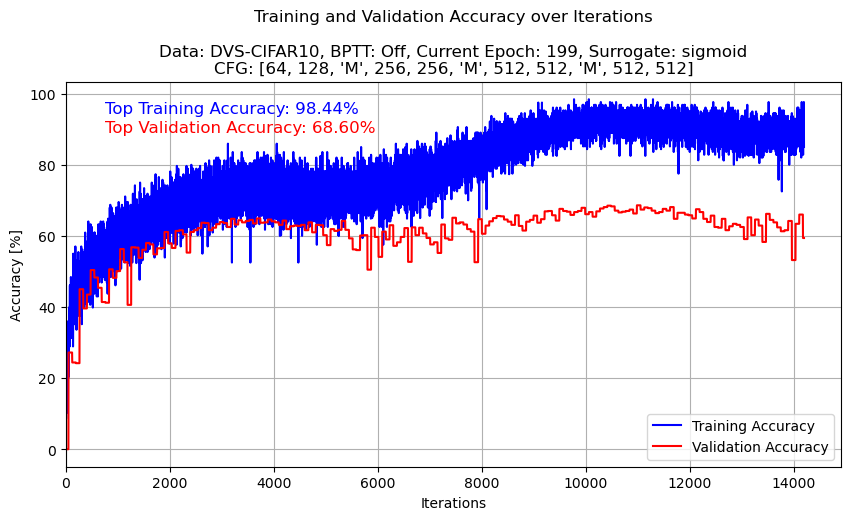

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
cfg = hyperparameters['cfg']
surrogate = hyperparameters['surrogate']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# 텍스트 추가
plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate}\nCFG: {cfg}'
plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()